# ****EPL 2023-24 Season Comprehensive Data Analysis with Machine Learning - Can İpek****

# Libraries

In [2]:
#pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 3.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [72]:
import numpy as np
import pandas as pd
import math

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import matplotlib
import seaborn as sns

import requests
from bs4 import BeautifulSoup
import json
from pandas import json_normalize
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree

import mplsoccer
from mplsoccer.pitch import Pitch

# Web Scrapping
(If you have previously exported .csv files, pass this section.)

In [5]:
url = f"https://understat.com/league/EPL/2023"

res = requests.get(url)
soup = BeautifulSoup(res.content, 'lxml')
scripts = soup.find_all('script')

# df_game_hist Data

strings = scripts[2].string

ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')

data = json.loads(json_data)

rows = []
for team_id, team_info in data.items():
    for record in team_info['history']:
        record['team_id'] = team_id
        record['team_title'] = team_info['title']
        record['ppda_att'] = record['ppda']['att']
        record['ppda_def'] = record['ppda']['def']
        record['ppda_allowed_att'] = record['ppda_allowed']['att']
        record['ppda_allowed_def'] = record['ppda_allowed']['def']
        del record['ppda'], record['ppda_allowed']
        record['oppda'] = (record['ppda_allowed_att'] / record['ppda_allowed_def'])
        record['ppda'] = (record['ppda_att'] / record['ppda_def'])
        # del record['ppda_allowed_def'], record['ppda_def'], record['ppda_allowed_att'], record['ppda_att']
        rows.append(record)

df_game_hist = pd.DataFrame(rows)

# df_games Data

strings = scripts[1].string

ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')

data = json.loads(json_data)
df_games = json_normalize(data)
df_games.dropna(inplace=True)

# df_players Data

strings = scripts[3].string

ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')

data = json.loads(json_data)
df_players = json_normalize(data)

# Using a "for" loop to reach data for each match individually (this will take time)
# df_shots & df_appear Data

df_matches = df_games.dropna()
df_shots = pd.DataFrame()
df_appear = pd.DataFrame()
base_url = 'https://understat.com/match/'

for match in df_matches["id"]:

    # Reaching the website
    url = base_url+match

    res = requests.get(url)
    soup = BeautifulSoup(res.content, 'lxml')
    scripts = soup.find_all('script')

    # df_shots Data
    strings = scripts[1].string

    ind_start = strings.index("('")+2 
    ind_end = strings.index("')") 
    json_data = strings[ind_start:ind_end] 
    json_data = json_data.encode('utf8').decode('unicode_escape')

    data = json.loads(json_data)

    data_h = data["h"]
    data_a = data["a"]

    data_h = json_normalize(data_h)
    data_a = json_normalize(data_a)

    df_temp = pd.concat([data_a, data_h])
    df_temp["match_id"] = match
    df_shots = pd.concat([df_shots, df_temp])

    # df_appear Data
    strings= scripts[2].string

    ind_start = strings.index("('")+2 
    ind_end = strings.index("')") 
    json_data = strings[ind_start:ind_end] 
    json_data = json_data.encode('utf8').decode('unicode_escape')

    data_events = json.loads(json_data)

    data_events_h = data_events["h"].values()
    data_events_a = data_events["a"].values()

    data_events_h = pd.DataFrame(data_events_h)
    data_events_a = pd.DataFrame(data_events_a)

    df_temp_events = pd.concat([data_events_a, data_events_h])
    df_temp_events["match_id"] = match
    df_appear = pd.concat([df_appear, df_temp_events])

### exporting as .csv
(Run to export scrapped .csv files to use in the next run.)

In [ ]:
df_appear.to_csv('df_appear.csv', index=False)
df_shots.to_csv('df_shots.csv', index=False)
df_players.to_csv('df_players.csv', index=False)
df_games.to_csv('df_games.csv', index=False)
df_game_hist.to_csv('df_game_hist.csv', index=False)

###  importing from .csv
(Run if you have the .csv files, pass if you already scrapped the data)

In [ ]:
df_appear = pd.read_csv('df_appear.csv')
df_shots = pd.read_csv('df_shots.csv')
df_players = pd.read_csv('df_players.csv')
df_games = pd.read_csv('df_games.csv')
df_game_hist = pd.read_csv('df_game_hist.csv')

## Preview for the data

In [6]:
df_appear.head()

id goals own_goals shots                   xG time player_id team_id  \
0  603619     0         0     0                    0   90      6054      88   
1  603620     0         0     0                    0   90       638      88   
2  603621     0         0     1  0.10935002565383911   84       579      88   
3  603622     0         0     0                    0   90      6490      88   
4  603623     0         0     0                    0   84     10847      88   

  position         player  ... red_card roster_in roster_out key_passes  \
0       GK        Ederson  ...        0         0          0          0   
1       DR    Kyle Walker  ...        0    603633          0          1   
2       DC     Nathan Aké  ...        0    603632          0          0   
3       DC  Manuel Akanji  ...        0         0          0          0   
4       DL     Rico Lewis  ...        0    603631          0          0   

  assists                    xA              xGChain            xGBuildup  \
0       0                     0  0.25525736808776855  0.25525736808776855   
1       0  0.014352702535688877  0.48293280601501465  0.46858009696006775   
2       0                     0  0.37426090240478516  0.37426090240478516   
3       0                     0  0.48747456073760986  0.48747456073760986   
4       0                     0  0.37426090240478516  0.37426090240478516   

  positionOrder match_id  
0             1    22275  
1             2    22275  
2             3    22275  
3             3    22275  
4             4    22275  

[5 rows x 22 columns]

In [73]:
df_appear.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11384 entries, 603619 to 663125
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          11384 non-null  int64  
 1   goals          11384 non-null  int64  
 2   own_goals      11384 non-null  int64  
 3   shots          11384 non-null  int64  
 4   xG             11384 non-null  float64
 5   time           11384 non-null  int64  
 6   player_id      11384 non-null  int64  
 7   team_id        11384 non-null  int64  
 8   position       11384 non-null  object 
 9   player         11384 non-null  object 
 10  h_a            11384 non-null  object 
 11  yellow_card    11384 non-null  int64  
 12  red_card       11384 non-null  int64  
 13  roster_in      11384 non-null  int64  
 14  roster_out     11384 non-null  int64  
 15  key_passes     11384 non-null  int64  
 16  assists        11384 non-null  int64  
 17  xA             11384 non-null  float64
 18  xGCha

In [74]:
df_shots.head()

id  minute       result      X      Y        xG           player h_a  \
0  531929       3         Goal  0.937  0.506  0.505846   Erling Haaland   a   
1  531930       5  MissedShots  0.719  0.389  0.018894  Kevin De Bruyne   a   
2  531931      10  MissedShots  0.952  0.421  0.130247   Erling Haaland   a   
3  531935      35         Goal  0.891  0.385  0.113214   Erling Haaland   a   
4  531937      45    SavedShot  0.898  0.482  0.168700       Phil Foden   a   

   player_id   situation  ...   shotType match_id   h_team           a_team  \
0       8260  FromCorner  ...   LeftFoot    22275  Burnley  Manchester City   
1        447    OpenPlay  ...  RightFoot    22275  Burnley  Manchester City   
2       8260    OpenPlay  ...  RightFoot    22275  Burnley  Manchester City   
3       8260    OpenPlay  ...   LeftFoot    22275  Burnley  Manchester City   
4       6055    OpenPlay  ...   LeftFoot    22275  Burnley  Manchester City   

  h_goals  a_goals                 date  player_assisted lastAction isGoal  
0       0        3  2023-08-11 19:00:00            Rodri   HeadPass      1  
1       0        3  2023-08-11 19:00:00       Phil Foden       Pass      0  
2       0        3  2023-08-11 19:00:00  Kevin De Bruyne      Cross      0  
3       0        3  2023-08-11 19:00:00   Julián Álvarez       Pass      1  
4       0        3  2023-08-11 19:00:00    Mateo Kovacic     TakeOn      0  

[5 rows x 21 columns]

In [75]:
df_shots.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10524 entries, 0 to 5
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               10524 non-null  int64  
 1   minute           10524 non-null  int64  
 2   result           10524 non-null  object 
 3   X                10524 non-null  float64
 4   Y                10524 non-null  float64
 5   xG               10524 non-null  float64
 6   player           10524 non-null  object 
 7   h_a              10524 non-null  object 
 8   player_id        10524 non-null  int64  
 9   situation        10524 non-null  object 
 10  season           10524 non-null  int64  
 11  shotType         10524 non-null  object 
 12  match_id         10524 non-null  int64  
 13  h_team           10524 non-null  object 
 14  a_team           10524 non-null  object 
 15  h_goals          10524 non-null  int64  
 16  a_goals          10524 non-null  int64  
 17  date             1052

In [76]:
df_players.head()

id      player_name  games  time  goals         xG  assists         xA  \
0  8260   Erling Haaland     31  2581     27  31.653997        5   4.751756   
1  8497      Cole Palmer     34  2640     22  17.832245       11  11.869294   
2  5232   Alexander Isak     30  2305     21  22.074266        2   3.652040   
3  1679  Dominic Solanke     38  3346     19  21.406831        3   3.543750   
4  6055       Phil Foden     35  2895     19  11.307983        8   8.516233   

   shots  key_passes  yellow_cards  red_cards position  \
0    122          29             1          0      F S   
1    108          72             7          0    F M S   
2     78          27             1          0      F S   
3    109          39             3          0      F S   
4    105          73             2          0    F M S   

                team_title  npg       npxG    xGChain  xGBuildup  
0          Manchester City   20  25.564646  30.197254   3.128645  
1  Chelsea,Manchester City   13  10.981725  31.036520  15.302413  
2         Newcastle United   16  17.507253  24.041152   5.754798  
3              Bournemouth   17  19.123324  22.588012   4.080138  
4          Manchester City   19  11.307983  30.416967  16.998998

In [77]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            570 non-null    int64  
 1   player_name   570 non-null    object 
 2   games         570 non-null    int64  
 3   time          570 non-null    int64  
 4   goals         570 non-null    int64  
 5   xG            570 non-null    float64
 6   assists       570 non-null    int64  
 7   xA            570 non-null    float64
 8   shots         570 non-null    int64  
 9   key_passes    570 non-null    int64  
 10  yellow_cards  570 non-null    int64  
 11  red_cards     570 non-null    int64  
 12  position      570 non-null    object 
 13  team_title    570 non-null    object 
 14  npg           570 non-null    int64  
 15  npxG          570 non-null    float64
 16  xGChain       570 non-null    float64
 17  xGBuildup     570 non-null    float64
dtypes: float64(5), int64(10), obje

In [78]:
df_games.head()

id  isResult             datetime  h.id      h.title h.short_title  \
0  22275         1  2023-08-11 19:00:00    92      Burnley           BUR   
1  22276         1  2023-08-12 11:30:00    83      Arsenal           ARS   
2  22277         1  2023-08-12 14:00:00    73  Bournemouth           BOU   
3  22278         1  2023-08-12 14:00:00   220     Brighton           BRI   
4  22279         1  2023-08-12 14:00:00    72      Everton           EVE   

   a.id            a.title a.short_title  goals.h  goals.a      xG.h  \
0    88    Manchester City           MCI        0        3  0.311032   
1   249  Nottingham Forest           NOT        2        1  0.842620   
2    81           West Ham           WHU        1        1  1.510250   
3   256              Luton           LUT        4        1  4.367480   
4   228             Fulham           FLH        0        1  2.590010   

       xG.a  forecast.w  forecast.d  forecast.l  
0  2.400740      0.0177      0.0854      0.8969  
1  0.966305      0.2797      0.3363      0.3840  
2  1.483400      0.3559      0.3169      0.3272  
3  1.885940      0.8790      0.0876      0.0334  
4  1.581440      0.6371      0.1989      0.1640

In [79]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             380 non-null    int64  
 1   isResult       380 non-null    int64  
 2   datetime       380 non-null    object 
 3   h.id           380 non-null    int64  
 4   h.title        380 non-null    object 
 5   h.short_title  380 non-null    object 
 6   a.id           380 non-null    int64  
 7   a.title        380 non-null    object 
 8   a.short_title  380 non-null    object 
 9   goals.h        380 non-null    int64  
 10  goals.a        380 non-null    int64  
 11  xG.h           380 non-null    float64
 12  xG.a           380 non-null    float64
 13  forecast.w     380 non-null    float64
 14  forecast.d     380 non-null    float64
 15  forecast.l     380 non-null    float64
dtypes: float64(5), int64(6), object(5)
memory usage: 47.6+ KB


In [80]:
df_game_hist.head()

id  h_a        xG       xGA      npxG     npxGA  deep  deep_allowed  \
0  22275.0    0  2.400740  0.311032  2.400740  0.311032     9             4   
1  22275.0    1  0.311032  2.400740  0.311032  2.400740     4             9   
2  22276.0    1  0.842620  0.966305  0.842620  0.966305     9             4   
3  22276.0    0  0.966305  0.842620  0.966305  0.842620     4             9   
4  22279.0    1  2.590010  1.581440  2.590010  1.581440     7             6   

   scored  missed  ...  pts     npxGD team_id         team_title  ppda_att  \
0       3       0  ...    3  2.089708      88    Manchester City       237   
1       0       3  ...    0 -2.089708      92            Burnley       463   
2       2       1  ...    3 -0.123685      83            Arsenal       108   
3       1       2  ...    0  0.123685     249  Nottingham Forest       441   
4       0       1  ...    0  1.008570      72            Everton       341   

   ppda_def  ppda_allowed_att  ppda_allowed_def      oppda       ppda  
0        15               463                14  33.071429  15.800000  
1        14               237                15  15.800000  33.071429  
2        27               441                10  44.100000   4.000000  
3        10               108                27   4.000000  44.100000  
4        23               174                10  17.400000  14.826087  

[5 rows x 26 columns]

In [81]:
df_game_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                760 non-null    float64
 1   h_a               760 non-null    int64  
 2   xG                760 non-null    float64
 3   xGA               760 non-null    float64
 4   npxG              760 non-null    float64
 5   npxGA             760 non-null    float64
 6   deep              760 non-null    int64  
 7   deep_allowed      760 non-null    int64  
 8   scored            760 non-null    int64  
 9   missed            760 non-null    int64  
 10  xpts              760 non-null    float64
 11  result            760 non-null    float64
 12  date              760 non-null    object 
 13  wins              760 non-null    int64  
 14  draws             760 non-null    int64  
 15  loses             760 non-null    int64  
 16  pts               760 non-null    int64  
 1

# Feature Engineering

## Convert string columns to numeric

In [82]:
def convert_to_num(df):
    for column in df.columns:
        try:
            df[column] = df[column].astype(float)
            if (df[column].astype(int) == df[column]).all():
                df[column] = df[column].astype(int)
        except ValueError:
            continue
    return df

In [83]:
df = [df_shots, df_games, df_game_hist, df_appear, df_players]
for i in df:
    i = convert_to_num(i)

In [84]:
df_shots['isGoal'] = (df_shots['result'] == 'Goal').astype(int)

## df_team_shots creator function

In [85]:
def team_specific_shots(team):
    df_team_shots = pd.DataFrame()
    df_team_shots = df_shots[((df_shots["h_team"] == team) & (df_shots["h_a"] == "h")) | ((df_shots["a_team"] == team) & (df_shots["h_a"] == "a"))]
    return df_team_shots

### df_teams

In [86]:
df_teams = df_game_hist[['team_title', "xG", "npxG", "deep", "oppda", "scored", "pts", "xpts", "xGA", "deep_allowed", "ppda", "missed", "npxGD", "wins", "draws", "loses"]] 
df_teams = df_teams.groupby('team_title')[["xG", "npxG", "deep", "oppda", "scored", "pts", "xpts", "xGA", "deep_allowed", "ppda", "missed", "npxGD", "wins", "draws", "loses"]].agg(["mean", "sum"])

### df_game_hist

In [87]:
df_game_hist.columns

Index(['id', 'h_a', 'xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed',
       'scored', 'missed', 'xpts', 'result', 'date', 'wins', 'draws', 'loses',
       'pts', 'npxGD', 'team_id', 'team_title', 'ppda_att', 'ppda_def',
       'ppda_allowed_att', 'ppda_allowed_def', 'oppda', 'ppda'],
      dtype='object')

In [88]:
# df_game_hist = pd.merge(df_game_hist, df_games[['datetime', 'h.id', 'id']], right_on = ['datetime', 'h.id'], left_on = ['date', 'team_id'], how = 'inner')
df_game_hist['h_a'] = (df_game_hist['h_a'] == 'h').astype(int)
# df_game_hist.drop(['datetime', 'date'], axis = 1, inplace = True)
games_hist_cols = list(df_game_hist.columns)

games_hist_cols.append('id')

df_games_total = pd.merge(df_games, df_game_hist, left_on = ["datetime", "h.id"], right_on = ["date", "team_id"], how = "right")

df_game_hist = pd.merge(df_games, df_games_total, left_on = ["datetime", "a.id"], right_on = ["date", "team_id"], how = "outer")

df_game_hist.drop(['isResult_x', 'datetime_x', 'h.id_x', 'h.title_x','h.short_title_x', 'a.id_x', 'a.title_x', 'a.short_title_x','goals.h_x', 'goals.a_x', 'xG.h_x', 'xG.a_x', 'forecast.w_x','forecast.d_x', 'forecast.l_x', 'isResult_y', 'datetime_y','h.id_y', 'h.title_y', 'h.short_title_y', 'a.id_y', 'a.title_y','a.short_title_y', 'goals.h_y', 'goals.a_y', 'xG.h_y', 'xG.a_y','forecast.w_y', 'forecast.d_y', 'forecast.l_y'], axis = 1, inplace = True)

df_game_hist['id_x'] = df_game_hist['id_x'].fillna(df_game_hist['id_y'])

df_game_hist.drop('id_y', axis = 1, inplace = True)

cols = list(df_games.columns)
cols.pop(0)

df_game_hist.columns = ['id', 'h_a', 'xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed','scored', 'missed', 'xpts', 'result', 'date', 'wins', 'draws', 'loses','pts', 'npxGD', 'team_id', 'team_title', 'ppda_att', 'ppda_def','ppda_allowed_att', 'ppda_allowed_def', 'oppda', 'ppda']

df_games_total_team = df_game_hist[(df_game_hist["team_id"] == team_id)]

# df_games_total.drop(columns = cols, inplace = True)

ValueError: Length mismatch: Expected axis has 27 elements, new values have 26 elements

### Creating Match Based Cummulative xG Data for "xG Based on Minute" part

In [ ]:
#df_xgtime = df_appear[df_appear["player_id"] == plid]
df_xgtime = df_appear

In [ ]:
df_xgtime["entered"] = df_xgtime["roster_out"].apply(lambda x: 0 if x == 0 else (90 - int(df_xgtime[df_xgtime["roster_out"] == x]["time"])))

In [ ]:
df_xgtime = df_xgtime[["entered", "player_id", "match_id", "player"]]

In [ ]:
xG_cummulative = float(0)
xG_dict_cumm = {}

xG_min_cummulative = float(0)
xG_min_dict_cumm = {}

df_min_xg = pd.merge(df_xgtime, df_shots, on=['player_id', 'match_id'], how='inner')
df_min_xg["time"] = df_min_xg["minute"] - df_min_xg["entered"]

for i in range(100):
    xG_cummulative = xG_cummulative + sum(df_min_xg[df_min_xg["time"] == i]["xG"])
    xG_dict_cumm[i] = xG_cummulative

    xG_min_cummulative = xG_min_cummulative + sum(df_min_xg[df_min_xg["minute"] == i]["xG"])
    xG_min_dict_cumm[i] = xG_min_cummulative

In [ ]:
df_min_xg['isGoal'] = (df_min_xg['result'] == 'Goal').astype(int)

In [ ]:
xG_norm = float(0)
xG_dict = {}
xG_min_norm = float(0)
xG_min_dict = {}

for i in range(100):
    xG_norm = np.sum(df_min_xg[df_min_xg["time"] == i]["xG"])
    xG_min_norm = np.sum(df_min_xg[df_min_xg["minute"] == i]["xG"])
    xG_dict[i] = xG_norm
    xG_min_dict[i] = xG_min_norm

### Creating Position based Data for "" part

In [89]:
df_player_xg_pos = pd.merge(df_min_xg, df_players, left_on = "player_id", right_on = "id", how = "inner")[["time_x", "player_x", "player_id", "match_id", "xG_x", "id_x", "position"]]

df_player_xg_pos['main_pos'] = df_player_xg_pos['position'].apply(lambda x: x[0])

In [90]:
df_player_xg_pos.groupby("main_pos").size()

main_pos
D    2542
F    5232
G      10
M    2680
S      60
dtype: int64

In [91]:
2270 + 4605 + 2568

9443

In [92]:
avg_player_per_match = (np.mean(df_player_xg_pos[df_player_xg_pos["main_pos"] != "G"].groupby("match_id")["player_id"].agg("size")))/2

## Data for Machine Learning (games_reg_match)

In [93]:
df_team_stats = df_game_hist.groupby(['team_id', 'team_title'])[['xG','xGA','npxG','deep','deep_allowed','scored','missed','xpts','wins','draws','loses', 'pts', 'npxGD', 'oppda', 'ppda']].mean()

df_team_stats.reset_index(inplace = True)

games_reg_temp = pd.merge(df_team_stats, df_games[['h.id', 'a.id', 'id']], left_on = ['team_id'], right_on = ['h.id'], how = 'inner')
games_reg = pd.merge(games_reg_temp, df_team_stats, left_on = ['a.id'], right_on = ['team_id'], how = 'inner', suffixes=('', '_opp'))

df_game_hist['result'] = df_game_hist['result'].replace({'w': 0, 'd': 0.5, 'l': 1})

games_reg_match = pd.merge(games_reg, df_game_hist.drop('date', axis = 1), on = ['id'], how = 'inner', suffixes=('', '_m'))

mask = games_reg_match['h_a'] == 0
games_reg_match.loc[mask, ['team_title', 'xG', 'xGA', 'npxG', 'deep', 'deep_allowed','scored', 'missed', 'xpts', 'wins', 'draws', 'loses','pts', 'npxGD', 'oppda', 'ppda', 'team_id_opp', 'team_title_opp', 'xG_opp', 'xGA_opp', 'npxG_opp', 'deep_opp', 'deep_allowed_opp', 'scored_opp', 'missed_opp', 'xpts_opp', 'wins_opp', 'draws_opp', 'loses_opp','pts_opp', 'npxGD_opp', 'oppda_opp', 'ppda_opp']] = games_reg_match.loc[mask, ['team_title_opp', 'xG_opp', 'xGA_opp', 'npxG_opp', 'deep_opp', 'deep_allowed_opp', 'scored_opp', 'missed_opp', 'xpts_opp', 'wins_opp', 'draws_opp', 'loses_opp','pts_opp', 'npxGD_opp', 'oppda_opp', 'ppda_opp', 'team_id', 'team_title', 'xG', 'xGA', 'npxG', 'deep', 'deep_allowed','scored', 'missed', 'xpts', 'wins', 'draws', 'loses','pts', 'npxGD', 'oppda', 'ppda']].values

games_reg_match.drop('team_id', inplace = True, axis = 1)

games_reg_match_h = games_reg_match[games_reg_match['h_a'] == 1]
games_reg_match_a = games_reg_match[games_reg_match['h_a'] == 0]

## Detailed xG Data for Machine Learning (df_xg)

In [94]:
df_xg_ma = df_appear.groupby(['match_id', 'team_id'])[['goals', 'assists', 'shots', 'key_passes', 'xGChain', 'xGBuildup', 'xG', 'xA']].agg('sum')
df_xg_ma.reset_index(inplace = True)
df_xg_ma.columns = ['match_id', 'team_id', 'goals_ma', 'assists_ma', 'shots_ma', 'key_passes_ma', 'xGChain_ma', 'xGBuildup_ma', 'xG_ma', 'xA_ma']

df_xg_sga = df_xg_ma.groupby(['team_id'])[['goals_ma', 'assists_ma', 'shots_ma', 'key_passes_ma', 'xGChain_ma', 'xGBuildup_ma', 'xG_ma', 'xA_ma']].agg('mean')
df_xg_sga.reset_index(inplace = True)
df_xg_sga.columns = ['team_id', 'goals_sga', 'assists_sga', 'shots_sga', 'key_passes_sga', 'xGChain_sga', 'xGBuildup_sga', 'xG_sga', 'xA_sga']

df_xg_player = df_appear.groupby('player_id')[['xGChain', 'xGBuildup', 'xG', 'xA']].agg('mean')
df_xg_player.reset_index(inplace = True)

df_xg_ms = (pd.merge(df_appear[df_appear['roster_out'] == 0][['match_id', 'team_id', 'player_id']], df_xg_player, on = 'player_id', how = 'inner')).groupby(['match_id', 'team_id'])[['xGChain', 'xGBuildup', 'xG', 'xA']].agg('sum')
df_xg_ms.reset_index(inplace = True)
df_xg_ms.columns = ['match_id', 'team_id', 'xGChain_ms', 'xGBuildup_ms', 'xG_ms', 'xA_ms']

df_xg = pd.merge(pd.merge(df_xg_ms, df_xg_ma, on = ['match_id', 'team_id'], how = 'inner'), df_xg_sga, on = 'team_id', how = 'inner')

In [95]:
df_xg.head()

match_id  team_id  xGChain_ms  xGBuildup_ms     xG_ms     xA_ms  goals_ma  \
0     21925       81    3.000427      1.595697  1.318989  0.982317         2   
1     21925      256    2.353452      1.443966  1.098474  0.638571         1   
2     21926       72    2.845048      1.698363  1.197489  0.713974         2   
3     21926      238    1.756805      0.889026  0.885488  0.604149         1   
4     21927       88    6.985427      4.760343  2.268258  1.161925         5   

   assists_ma  shots_ma  key_passes_ma  ...     xG_ma     xA_ma  goals_sga  \
0           2         9              5  ...  1.225275  0.989219   1.526316   
1           1        16             12  ...  2.204367  1.914953   1.289474   
2           1        16              9  ...  3.260428  1.994915   1.052632   
3           1        13              7  ...  1.657545  0.520857   0.815789   
4           3         7              5  ...  2.040471  0.907200   2.473684   

   assists_sga  shots_sga  key_passes_sga  xGChain_sga  xGBuildup_sga  \
0     1.052632  11.815789        7.947368     3.199656       1.662045   
1     0.868421  11.342105        8.289474     2.994640       1.686545   
2     0.447368  13.315789        8.763158     3.562725       1.936749   
3     0.473684   9.578947        6.710526     2.316017       1.120860   
4     1.815789  18.289474       14.315789     8.463111       5.753248   

     xG_sga    xA_sga  
0  1.457723  0.993948  
1  1.339565  0.924970  
2  1.659403  1.133585  
3  1.120807  0.725271  
4  2.375891  1.788658  

[5 rows x 22 columns]

# Exploratory Data Analysis (EDA)

## Frequencies of Categorical Variables

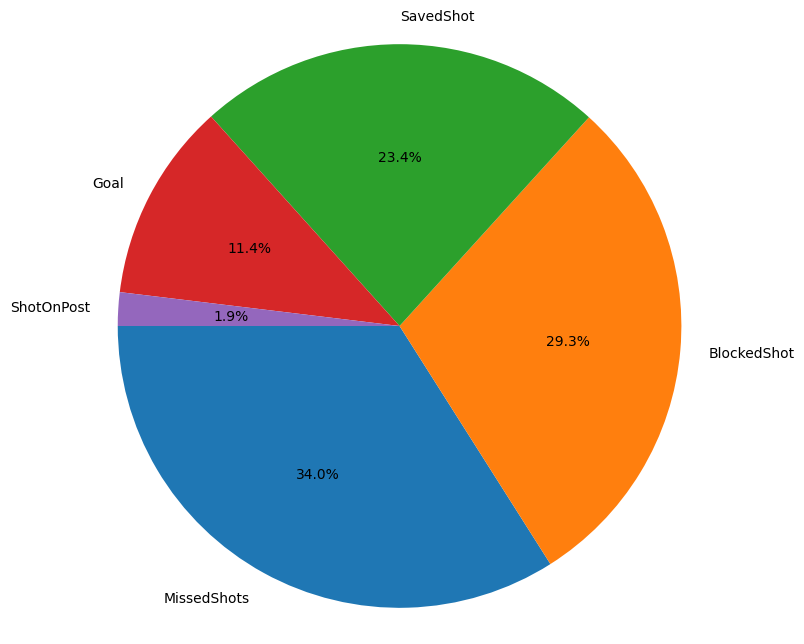

In [96]:
frequencies = df_shots['result'].value_counts()
frequencies = frequencies[frequencies > 50]

plt.figure(figsize=(8, 8))
plt.pie(frequencies, labels=frequencies.index, autopct='%1.1f%%', startangle=180)
plt.axis('equal')  # Eşit eksen oranı ile pastanın daire şeklinde olmasını sağlar
plt.show()

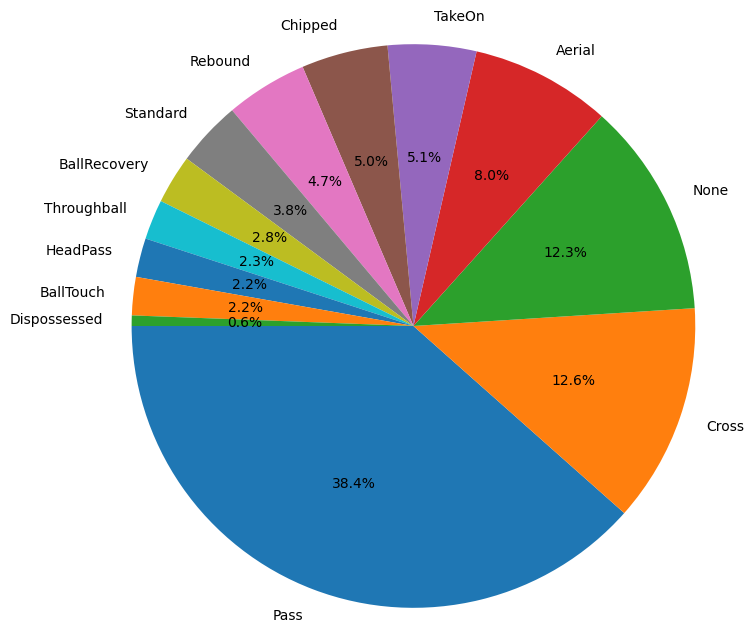

In [97]:
frequencies = df_shots['lastAction'].value_counts()
frequencies = frequencies[frequencies > 50]

plt.figure(figsize=(8, 8))
plt.pie(frequencies, labels=frequencies.index, autopct='%1.1f%%', startangle=180)
plt.axis('equal')  # Eşit eksen oranı ile pastanın daire şeklinde olmasını sağlar
plt.show()

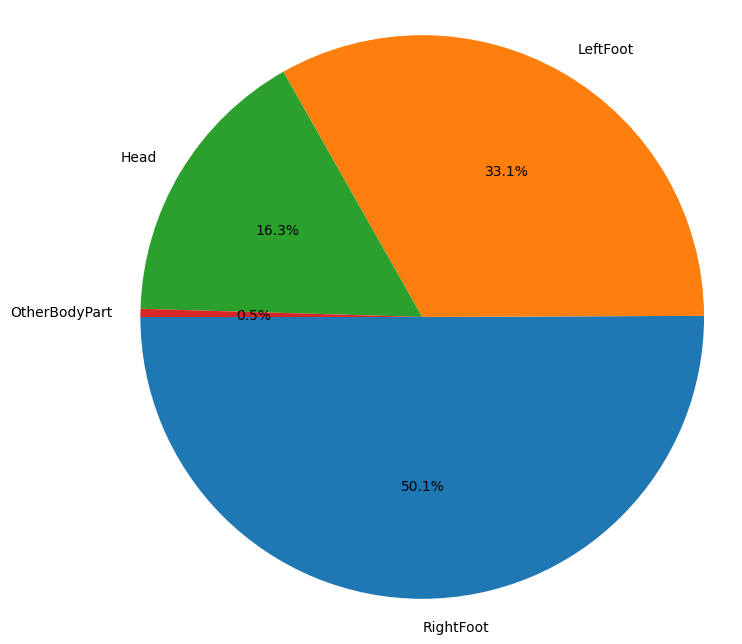

In [98]:
frequencies = df_shots['shotType'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(frequencies, labels=frequencies.index, autopct='%1.1f%%', startangle=180)
plt.axis('equal')  # Eşit eksen oranı ile pastanın daire şeklinde olmasını sağlar
plt.show()

In [99]:
frequencies = df_shots['situation'].value_counts()

# Pasta grafiğini oluşturalım
plt.figure(figsize=(8, 8))
plt.pie(frequencies, labels=frequencies.index, autopct='%1.1f%%', startangle=180)
plt.axis('equal')  # Eşit eksen oranı ile pastanın daire şeklinde olmasını sağlar
plt.show()

## Logistic Regression Curve and Confusion Matrix for Visualizing Predictive Pover of xG Metric

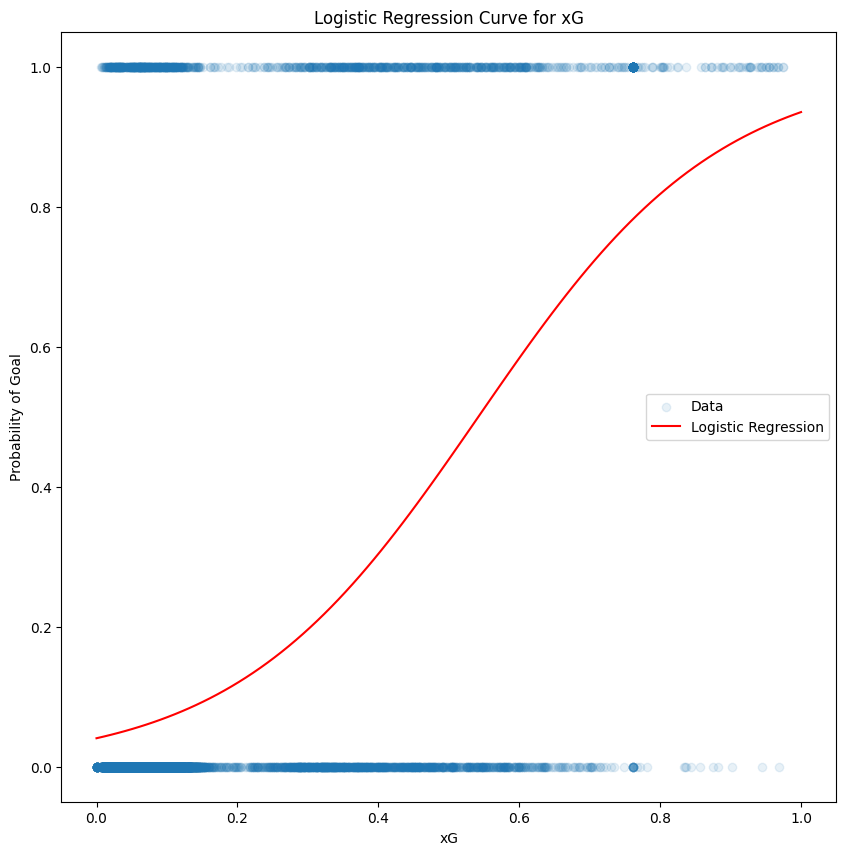

In [100]:
df = pd.DataFrame()
df = df_shots

model = LogisticRegression()
X = df[['xG']]
y = df['isGoal']
model.fit(X, y)

x_vals = np.linspace(0, 1, 100).reshape(-1, 1)
y_vals = model.predict_proba(x_vals)[:, 1]

plt.figure(figsize=(10, 10))
plt.scatter(df['xG'], df['isGoal'], alpha=0.1, label='Data')
plt.plot(x_vals, y_vals, color='red', label='Logistic Regression')
plt.xlabel('xG')
plt.ylabel('Probability of Goal')
plt.title('Logistic Regression Curve for xG')
plt.legend()
plt.show()

In [101]:
model = LogisticRegression()
X = df[['xG']]
y = df['isGoal']
model.fit(X, y)

y_pred = model.predict(X)

cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2f})')
plt.show()

# Accuracy'i yazdırma
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.90


## Histogram of Shot Count / xG Distribution 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='goals', ylabel='Count'>

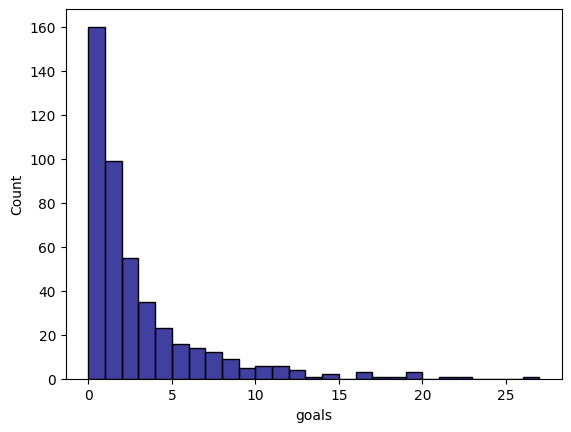

In [102]:
sns.histplot(df_players[df_players['xG'] > 0.01]['goals'], color = 'navy', binwidth = 1)

## xG Distribution on 5 minute-range Intervals by Teams (df_shots)

### Choose focus of the analysis

In [103]:
#team = input('Type team name: ')
team = 'Arsenal'
player = 'Declan Rice'
team_id = df_game_hist[df_game_hist['team_title'] == team]['team_id'].values[0]

In [104]:
df_team_shots = team_specific_shots(team)

### Using categorized time intervals instead of Countunious time variable to create an histogram.

In [105]:
def categorize_period(df):
    period = (df['minute'] // 5) * 5
    return f"{period}-{period + 4}"
df_team_shots['period'] = df_team_shots.apply(categorize_period, axis=1)

/tmp/ipykernel_36/3543908787.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team_shots['period'] = df_team_shots.apply(categorize_period, axis=1)


In [106]:
grouped_xG = df_team_shots.groupby('period')['xG'].agg(["mean", "sum"])
custom_order = ['0-4', '5-9', '10-14', '15-19',
                '20-24','25-29', '30-34', '35-39',
                '40-44','45-49', '50-54', '55-59',
                '60-64','65-69', '70-74', '75-79',
                '80-84','85-89', '90-94', '95-99']
grouped_xG = grouped_xG.reindex(custom_order)

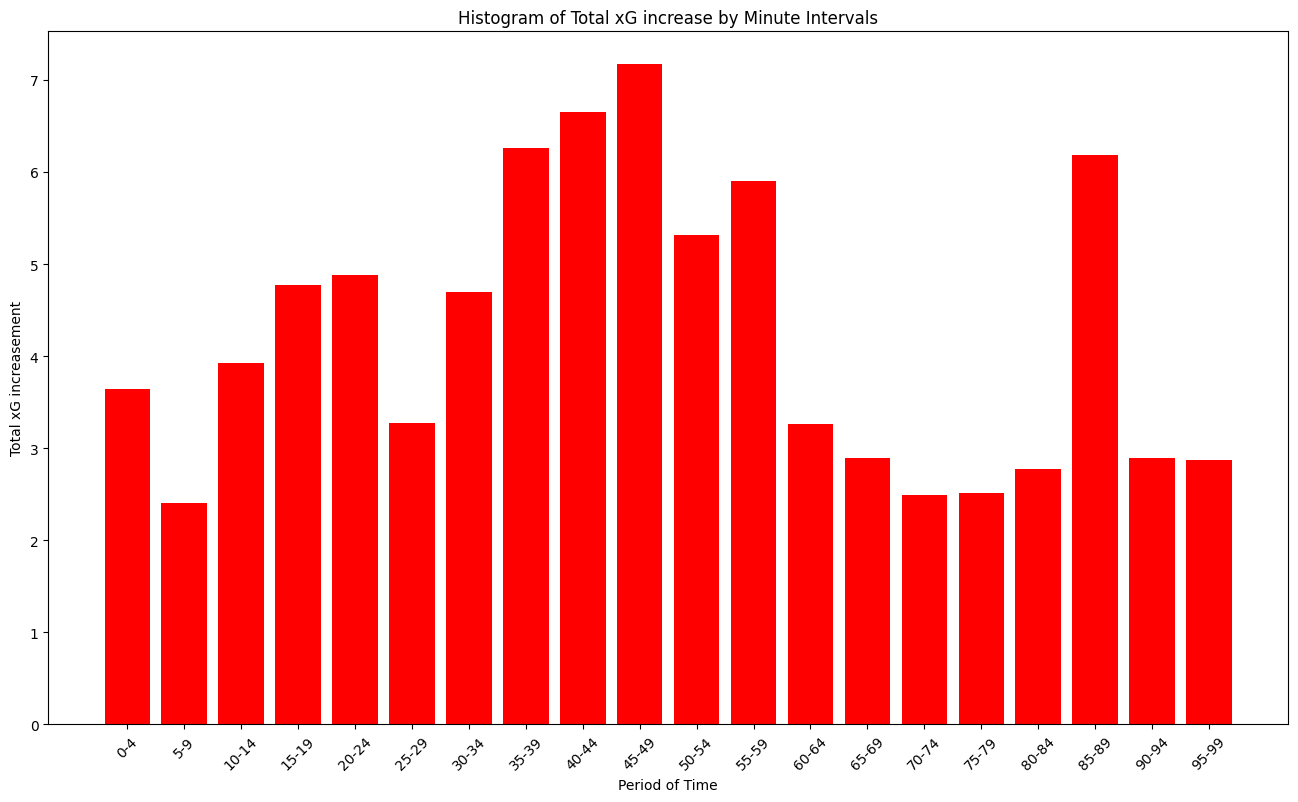

In [107]:
plt.figure(figsize=(16, 9))

plt.bar(grouped_xG.index, grouped_xG["sum"], color='red')

plt.xticks(rotation=45) 
plt.xlabel('Period of Time')
plt.ylabel('Total xG increasement')
plt.title('Histogram of Total xG increase by Minute Intervals')
plt.show()

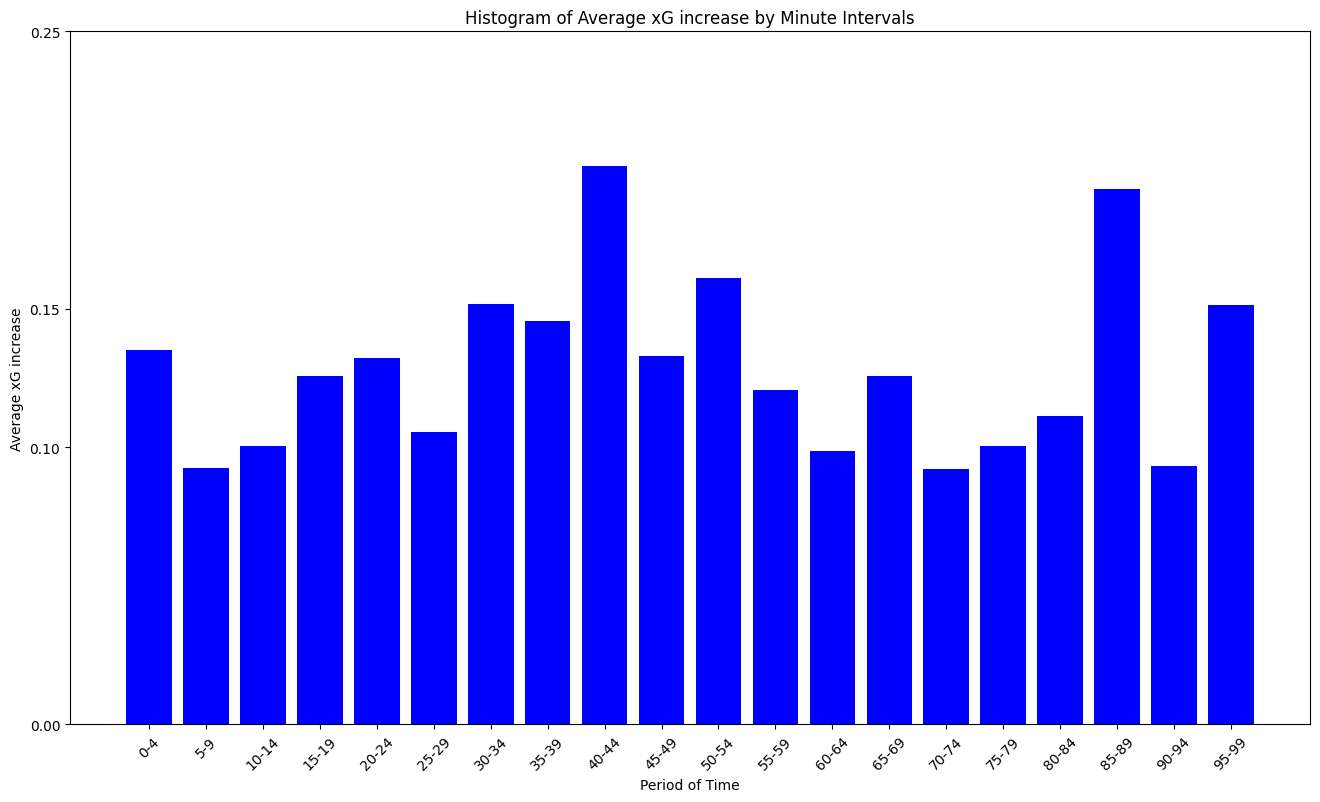

In [108]:
plt.figure(figsize=(16, 9))
plt.bar(grouped_xG.index, grouped_xG["mean"], color='blue')

plt.xticks(rotation=45)
plt.xlabel('Period of Time')
plt.ylabel('Average xG increase')
plt.yticks([0,0.1, 0.15, 0.25])
plt.title('Histogram of Average xG increase by Minute Intervals')
plt.show()

## xG based on Minute

## Cummulative average xG increment graph (based on players' time on field and munite of the game)

In [109]:
df_appear.reset_index(inplace = True)
df_appear.set_index("id", inplace = True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

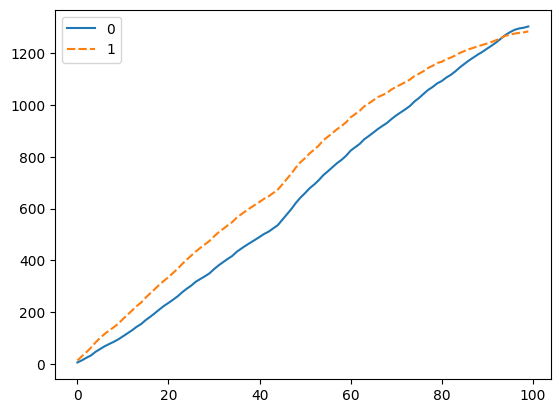

In [110]:
sns.lineplot([xG_min_dict_cumm, xG_dict_cumm])

## Visualization of difference between xG increment based on players' spent minutes on the field and xG increment based on minute of the game

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

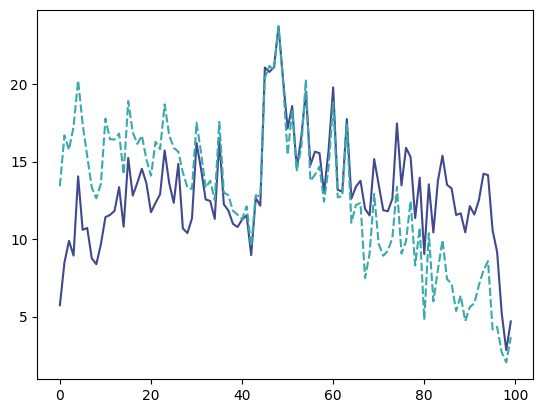

In [111]:
sns.lineplot([xG_min_dict, xG_dict], palette = 'mako', legend = False)

## Visualization of difference between actual goal count increment based on players' spent minutes on the field and actual goal count  increment based on minute of the game

In [112]:
goal_norm = float(0)
goal_dict = {}
goal_min_norm = float(0)
goal_min_dict = {}

for i in range(100):
    goal_norm = np.sum(df_min_xg[df_min_xg["time"] == i]["isGoal"])
    goal_min_norm = np.sum(df_min_xg[df_min_xg["minute"] == i]["isGoal"])
    goal_dict[i] = goal_norm
    goal_min_dict[i] = goal_min_norm

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

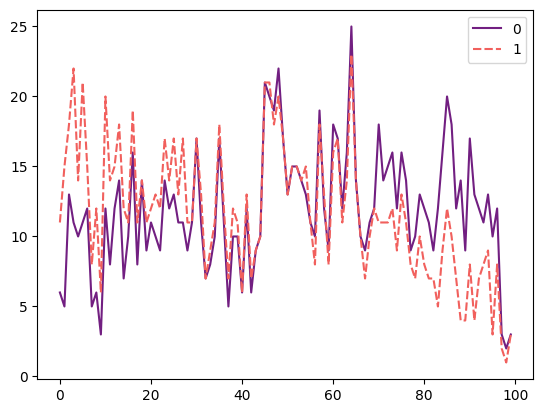

In [113]:
sns.lineplot([goal_min_dict, goal_dict], palette = 'magma')

## xG increment graph for any player compared with other players' averages based on main playing positions (forward, midfielder, defender and general)

In [114]:
df_xgtime_player = df_xgtime[df_xgtime["player"] == player]
df_player_min_xg = pd.merge(df_xgtime_player, df_shots, on=['player_id', 'match_id'], how='inner')
df_player_min_xg["time"] = df_player_min_xg["minute"] - df_player_min_xg["entered"]

In [115]:
xG_cummulative_player = float(0)
xG_dict_cumm_player = {}
for i in range(100):
    xG_cummulative_player = xG_cummulative_player + sum(df_player_min_xg[df_player_min_xg["time"] == i]["xG"])
    xG_dict_cumm_player[i] = xG_cummulative_player

In [116]:
xG_player = float(0)
xG_dict_player = {}
for i in range(100):
    xG_player = sum(df_player_min_xg[df_player_min_xg["time"] == i]["xG"])
    xG_dict_player[i] = xG_player

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

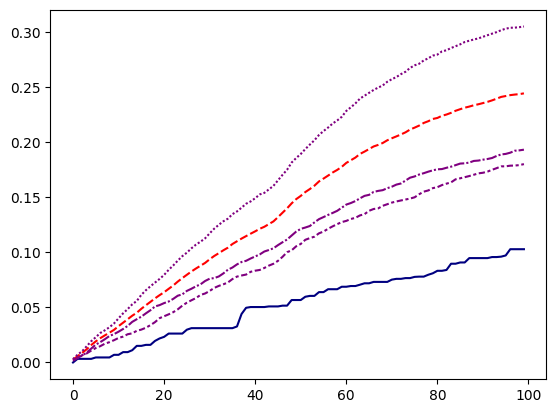

In [117]:
df_min_xg_fw = df_player_xg_pos[df_player_xg_pos["main_pos"] == "F"]
df_min_xg_def =  df_player_xg_pos[df_player_xg_pos["main_pos"] == "M"]
df_min_xg_mid =  df_player_xg_pos[df_player_xg_pos["main_pos"] == "D"]

general_xg_scaled = [x / (df_min_xg["match_id"].nunique() 
                          * avg_player_per_match
                         ) for x in list(xG_dict_cumm.values())]


xG_cummulative_fw = 0
xG_dict_cumm_fw = {}
for i in range(100):
    xG_cummulative_fw = xG_cummulative_fw + sum(df_min_xg_fw[df_min_xg_fw["time_x"] == i]["xG_x"])
    xG_dict_cumm_fw[i] = xG_cummulative_fw
fw_xg_scaled = [(x / (df_min_xg_fw["match_id"].nunique()
                       * avg_player_per_match * (4605/9443)
                     ))  for x in list(xG_dict_cumm_fw.values())]

xG_cummulative_def = 0
xG_dict_cumm_def = {}
for i in range(100):
    xG_cummulative_def = xG_cummulative_def + sum(df_min_xg_def[df_min_xg_def["time_x"] == i]["xG_x"])
    xG_dict_cumm_def[i] = xG_cummulative_def
def_xg_scaled = [(x / (df_min_xg_def["match_id"].nunique() 
                        * avg_player_per_match * (2270/9443) 
                      )) for x in list(xG_dict_cumm_def.values())]

xG_cummulative_mid = 0
xG_dict_cumm_mid = {}
for i in range(100):
    xG_cummulative_mid = xG_cummulative_mid + sum(df_min_xg_mid[df_min_xg_mid["time_x"] == i]["xG_x"])
    xG_dict_cumm_mid[i] = xG_cummulative_mid
mid_xg_scaled = [(x / (df_min_xg_mid["match_id"].nunique()
                        * avg_player_per_match * (2568/9443)
                      )) for x in list(xG_dict_cumm_mid.values())]
    

player_xg_scaled =  [x / df_player_min_xg["match_id"].nunique() for x in list(xG_dict_cumm_player.values())]

sns.lineplot([player_xg_scaled, general_xg_scaled, fw_xg_scaled, mid_xg_scaled, def_xg_scaled], palette = ['navy', 'red', 'purple', 'purple', 'purple'], legend = False)

## Attack Types & Heatmap

This section aims to examine the frequencies, rates and scoring probabilities of shots taken in terms of team, player and minute breakdowns, which can be adjusted in terms of three different features. Afterwards, the desired shot group is filtered and shown on the heat map.

For example, a coach who wants to obtain valuable data for the opposing team can filter the types of positions that the opposing team or any player on this team achieves most frequently or scores the most goals and visualize them on the field with a heat map.

### Filtering

In [118]:
shots_teams = pd.merge(df_shots, df_players[['id', 'team_title']], left_on = 'player_id', right_on = 'id', how = 'inner')

heatmap_target = shots_teams
# [
# (shots_teams['result'] != 'Goal')
# (shots_teams['team_title'] == 'Manchester City')
# & (shots_teams['player'] == 'Erling Haaland')
# & (shots_teams['h_a'] == 'h')
# & (shots_teams['shotType'] == 'LeftFoot')
# & (shots_teams['lastAction'] == 'Pass')
# & (shots_teams['situation'] == 'OpenPlay')
# & (shots_teams['minute'] > 50)
# ]
heatmap_target['Y'] *= 75
heatmap_target['X'] *= 115

In [119]:
heatmap_target

id_x  minute       result           X          Y        xG  \
0      531929       3         Goal  107.754996  37.949999  0.505846   
1      531930       5  MissedShots   82.685002  29.175001  0.018894   
2      531931      10  MissedShots  109.479996  31.574999  0.130247   
3      531935      35         Goal  102.464998  28.875000  0.113214   
4      531937      45    SavedShot  103.270004  36.150001  0.168700   
...       ...     ...          ...         ...        ...       ...   
10519  582073       6    SavedShot   89.354996  45.675001  0.076673   
10520  582074       9   ShotOnPost  107.064998  31.275001  0.325072   
10521  582083      32  BlockedShot   99.935002  44.250000  0.123004   
10522  582084      35  BlockedShot   92.345004  44.699999  0.042059   
10523  582091      79  MissedShots  100.050000  23.025001  0.065044   

                  player h_a  player_id       situation  ...  \
0         Erling Haaland   a       8260      FromCorner  ...   
1        Kevin De Bruyne   a        447        OpenPlay  ...   
2         Erling Haaland   a       8260        OpenPlay  ...   
3         Erling Haaland   a       8260        OpenPlay  ...   
4             Phil Foden   a       6055        OpenPlay  ...   
...                  ...  ..        ...             ...  ...   
10519      Gustavo Hamer   h      11839  DirectFreekick  ...   
10520  Ben Brereton Díaz   h      11815        OpenPlay  ...   
10521     Cameron Archer   h       9912        OpenPlay  ...   
10522      Gustavo Hamer   h      11839        OpenPlay  ...   
10523     Rhian Brewster   h       5569        OpenPlay  ...   

                 h_team           a_team  h_goals a_goals  \
0               Burnley  Manchester City        0       3   
1               Burnley  Manchester City        0       3   
2               Burnley  Manchester City        0       3   
3               Burnley  Manchester City        0       3   
4               Burnley  Manchester City        0       3   
...                 ...              ...      ...     ...   
10519  Sheffield United        Tottenham        0       3   
10520  Sheffield United        Tottenham        0       3   
10521  Sheffield United        Tottenham        0       3   
10522  Sheffield United        Tottenham        0       3   
10523  Sheffield United        Tottenham        0       3   

                      date  player_assisted  lastAction isGoal   id_y  \
0      2023-08-11 19:00:00            Rodri    HeadPass      1   8260   
1      2023-08-11 19:00:00       Phil Foden        Pass      0    447   
2      2023-08-11 19:00:00  Kevin De Bruyne       Cross      0   8260   
3      2023-08-11 19:00:00   Julián Álvarez        Pass      1   8260   
4      2023-08-11 19:00:00    Mateo Kovacic      TakeOn      0   6055   
...                    ...              ...         ...    ...    ...   
10519  2024-05-19 15:00:00             None    Standard      0  11839   
10520  2024-05-19 15:00:00    Gustavo Hamer     Chipped      0  11815   
10521  2024-05-19 15:00:00    Gustavo Hamer        Pass      0   9912   
10522  2024-05-19 15:00:00   Cameron Archer        Pass      0  11839   
10523  2024-05-19 15:00:00  Wes Foderingham        Pass      0   5569   

                         team_title  
0                   Manchester City  
1                   Manchester City  
2                   Manchester City  
3                   Manchester City  
4                   Manchester City  
...                             ...  
10519              Sheffield United  
10520              Sheffield United  
10521  Aston Villa,Sheffield United  
10522              Sheffield United  
10523              Sheffield United  

[10524 rows x 23 columns]

### Tables

In [120]:
heatmap_target['isGoal'] = (heatmap_target['result'] == 'Goal').astype(int)

In [121]:
df_lastAction = pd.crosstab(heatmap_target['lastAction'], heatmap_target['isGoal']).reset_index()
df_lastAction.columns = ['lastAction', 'miss', 'goal']
df_lastAction['goal_ratio'] = ((df_lastAction['goal'] / (df_lastAction['miss'] + df_lastAction['goal'])) * 100).round(2)
df_lastAction['act_ratio'] = (((df_lastAction['miss'] + df_lastAction['goal']) / sum(df_lastAction['miss'] + df_lastAction['goal'])) * 100).round(2)

In [122]:
df_lastAction.head()

lastAction  miss  goal  goal_ratio  act_ratio
0        Aerial   774    59        7.08       7.92
1  BallRecovery   249    42       14.43       2.77
2     BallTouch   210    17        7.49       2.16
3   BlockedPass    13     2       13.33       0.14
4          Card     1     0        0.00       0.01

In [123]:
df_shotType = pd.crosstab(heatmap_target['shotType'], heatmap_target['isGoal']).reset_index()
df_shotType.columns = ['shotType', 'miss', 'goal']
df_shotType['goal_ratio'] = ((df_shotType['goal'] / (df_shotType['miss'] + df_shotType['goal'])) * 100).round(2)
df_shotType['act_ratio'] = (((df_shotType['miss'] + df_shotType['goal']) / sum(df_shotType['miss'] + df_shotType['goal'])) * 100).round(2)

In [124]:
df_shotType.head()

shotType  miss  goal  goal_ratio  act_ratio
0           Head  1517   202       11.75      16.33
1       LeftFoot  3106   381       10.93      33.13
2  OtherBodyPart    42     7       14.29       0.47
3      RightFoot  4663   606       11.50      50.07

In [125]:
df_stituation = pd.crosstab(heatmap_target['situation'], heatmap_target['isGoal']).reset_index()
df_stituation.columns = ['situation', 'miss', 'goal']
df_stituation['goal_ratio'] = ((df_stituation['goal'] / (df_stituation['miss'] + df_stituation['goal'])) * 100).round(2)
df_stituation['act_ratio'] = (((df_stituation['miss'] + df_stituation['goal']) / sum(df_stituation['miss'] + df_stituation['goal'])) * 100).round(2)

In [126]:
df_stituation.head()

situation  miss  goal  goal_ratio  act_ratio
0  DirectFreekick   271    11        3.90       2.68
1      FromCorner  1634   162        9.02      17.07
2        OpenPlay  6884   873       11.25      73.71
3         Penalty    11    96       89.72       1.02
4        SetPiece   528    54        9.28       5.53

### Heatmap

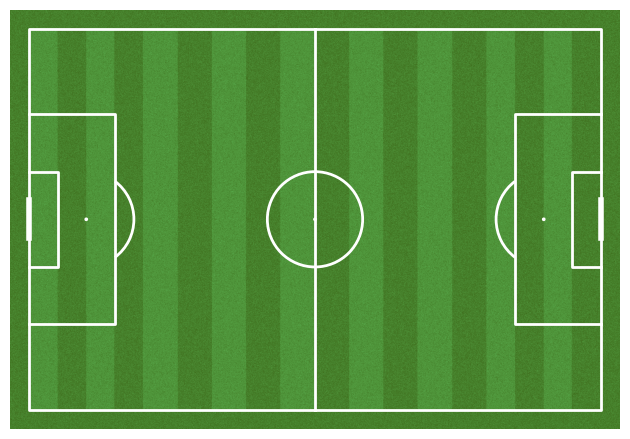

In [127]:
customcmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom cmap', [[0.3, 0, 1, 0],
                                                                                 [0.1, 0.2, 0.7, 0.2],
                                                                                 [0, 0.7, 0.3, 0.7],
                                                                                 'yellow',
                                                                                 'orange',
                                                                                 'red'])
pitch = Pitch(pitch_color='grass', line_color='white', stripe=True, pitch_width=1, line_zorder=2)
fig, ax = pitch.draw()
# sns.kdeplot(data = heatmap_target, x = 'X', y = 'Y',
#             cmap = customcmap,
#             shade = True,
#             n_levels = 1000,
#             ax=ax,
#             thresh=0,
#             zorder = 1)


In [128]:
df_shots['distance'] = np.sqrt((1 - df_shots['X'])**2 + (0.5 - df_shots['Y'])**2)

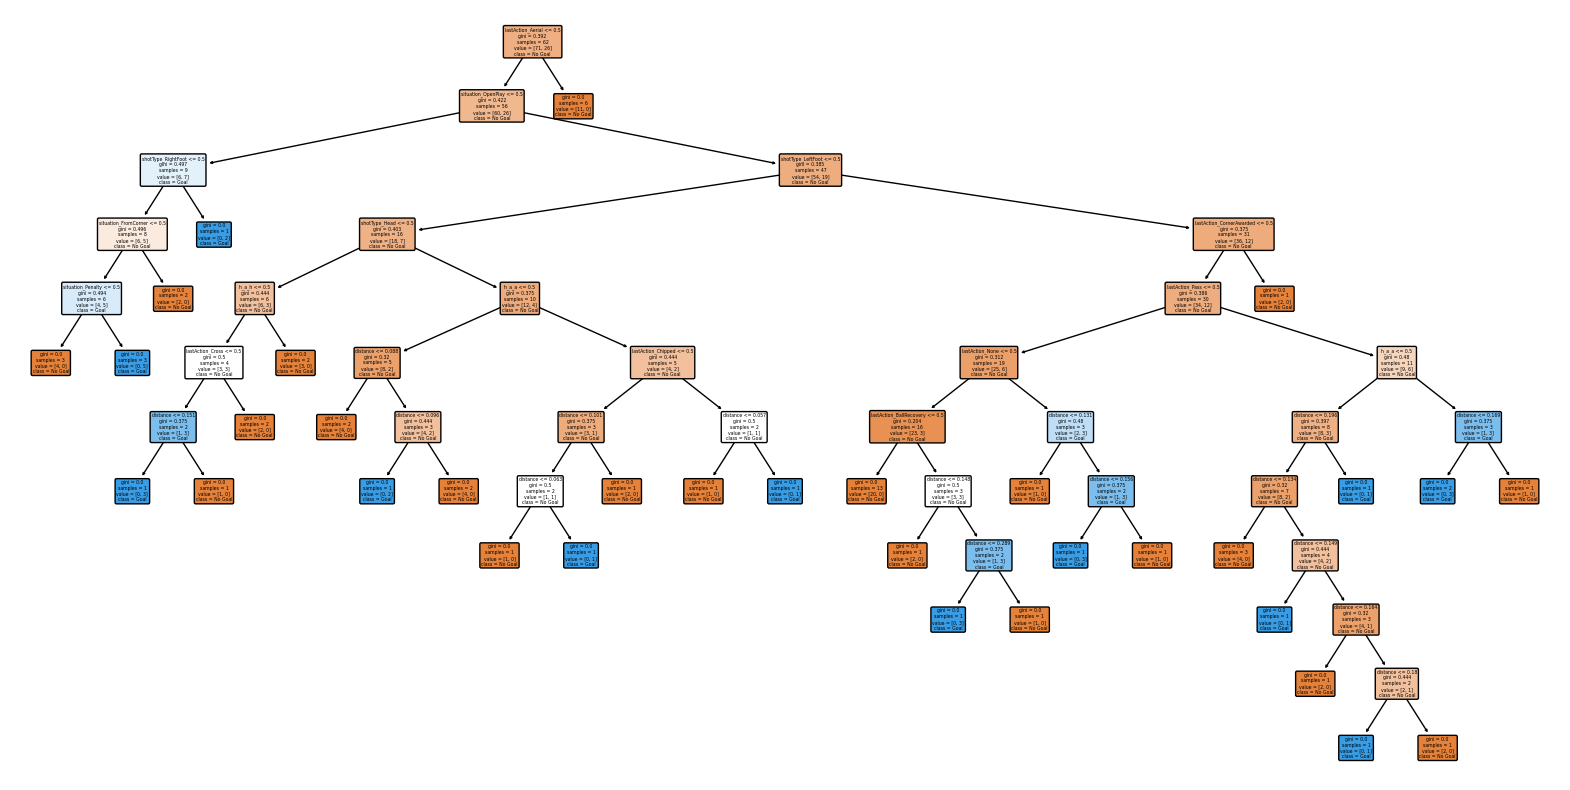

In [129]:
data = df_shots[df_shots['player'] == 'Erling Haaland'][['h_a','situation', 'shotType', 'lastAction', 'isGoal', 'distance']]

data = data.dropna()  # Eksik değerleri silme
X = data[['h_a', 'situation', 'shotType', 'lastAction', 'distance']]
y = data['isGoal']

X = pd.get_dummies(X, columns=['h_a', 'situation', 'shotType', 'lastAction'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

plt.figure(figsize=(20,10))
plot_tree(model.estimators_[0], feature_names=X.columns, class_names=['No Goal', 'Goal'], filled=True, rounded=True)
plt.show()

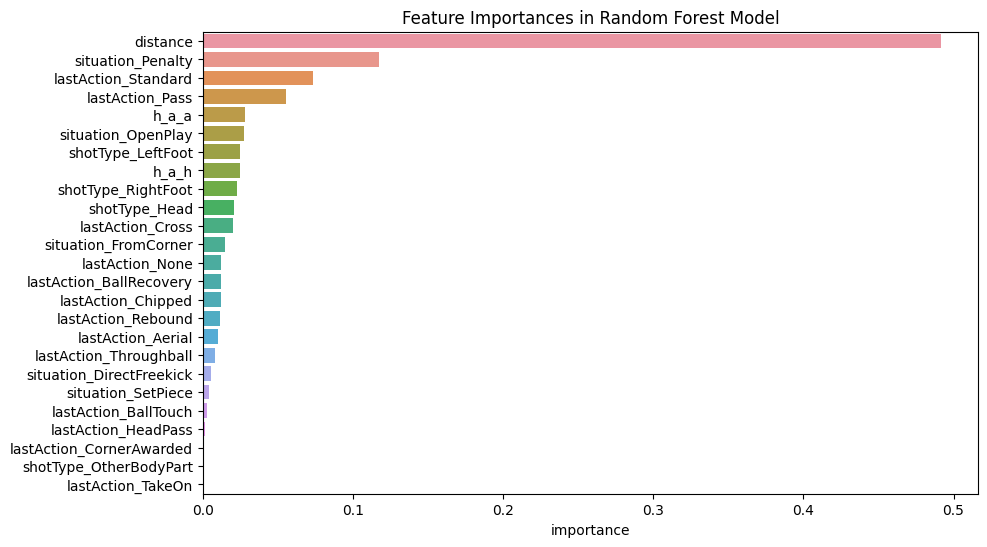

In [130]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importances in Random Forest Model')
plt.show()

In [131]:
data = df_shots[df_shots['player'] == 'Erling Haaland'][['h_a','situation', 'shotType', 'lastAction', 'xG', 'distance']]

data = data.dropna()  # Eksik değerleri silme
X = data[['h_a', 'situation', 'shotType', 'lastAction', 'distance']]
y = data['xG']

X = pd.get_dummies(X, columns=['h_a', 'situation', 'shotType', 'lastAction'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

plt.figure(figsize=(40,20))
plot_tree(model.estimators_[0], feature_names=X.columns, class_names=['No Goal', 'Goal'], filled=True, rounded=True)
plt.show()

In [132]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importances in Random Forest Model')
plt.show()

In [133]:
df_players['dif'] = df_players['goals'] - df_players['xG']

In [134]:
df_players.columns

Index(['id', 'player_name', 'games', 'time', 'goals', 'xG', 'assists', 'xA',
       'shots', 'key_passes', 'yellow_cards', 'red_cards', 'position',
       'team_title', 'npg', 'npxG', 'xGChain', 'xGBuildup', 'dif'],
      dtype='object')

In [135]:
df_players[['player_name', 'goals', 'xG', 'position','team_title', 'dif']].head()

player_name  goals         xG position               team_title  \
0   Erling Haaland     27  31.653997      F S          Manchester City   
1      Cole Palmer     22  17.832245    F M S  Chelsea,Manchester City   
2   Alexander Isak     21  22.074266      F S         Newcastle United   
3  Dominic Solanke     19  21.406831      F S              Bournemouth   
4       Phil Foden     19  11.307983    F M S          Manchester City   

        dif  
0 -4.653997  
1  4.167755  
2 -1.074266  
3 -2.406831  
4  7.692017

In [ ]:
df_general = {}
opp_id = 72
match_id = 22185
match = df_games[df_games["id"] == match_id]
total_opp_matches = int(df_game_hist[df_game_hist["team_id"] == opp_id].groupby("team_title").size())
total_matches = int(df_game_hist[df_game_hist["team_id"] == team_id].groupby("team_title").size())

In [ ]:
games_hist_cols = list(df_game_hist.columns)

games_hist_cols.append('id')

df_games_total = pd.merge(df_games, df_game_hist, left_on = ["datetime", "h.id"], right_on = ["date", "team_id"], how = "right")

df_game_hist = pd.merge(df_games, df_games_total, left_on = ["datetime", "a.id"], right_on = ["date", "team_id"], how = "outer")

df_game_hist.drop(['isResult_x', 'datetime_x', 'h.id_x', 'h.title_x','h.short_title_x', 'a.id_x', 'a.title_x', 'a.short_title_x','goals.h_x', 'goals.a_x', 'xG.h_x', 'xG.a_x', 'forecast.w_x','forecast.d_x', 'forecast.l_x', 'isResult_y', 'datetime_y','h.id_y', 'h.title_y', 'h.short_title_y', 'a.id_y', 'a.title_y','a.short_title_y', 'goals.h_y', 'goals.a_y', 'xG.h_y', 'xG.a_y','forecast.w_y', 'forecast.d_y', 'forecast.l_y'], axis = 1, inplace = True)

df_game_hist['id_x'] = df_game_hist['id_x'].fillna(df_game_hist['id_y'])

df_game_hist.drop('id_y', axis = 1, inplace = True)

cols = list(df_games.columns)
cols.pop(0)


df_game_hist.drop('id', axis = 1,inplace = True)

df_game_hist.columns = ['id', 'h_a', 'xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed','scored', 'missed', 'xpts', 'result', 'date', 'wins', 'draws', 'loses','pts', 'npxGD', 'team_id', 'team_title', 'ppda_att', 'ppda_def','ppda_allowed_att', 'ppda_allowed_def', 'oppda', 'ppda']
df_games_total_team = df_game_hist[(df_game_hist["team_id"] == team_id)]

# df_games_total.drop(columns = cols, inplace = True)

# The Machine Learning

## Get Correlation Coefficents (games_reg_match_corr)

In [136]:
games_reg_match_corr = games_reg_match.drop(['team_title', 'id', 'h.id', 'a.id', 'team_id_opp','team_title_opp', 'team_title_m'], axis=1).corr()[['xG_m',
 'xGA_m',
 'npxG_m',
 'npxGA',
 'deep_m',
 'deep_allowed_m',
 'scored_m',
 'missed_m',
 'xpts_m',
 'result',
 'wins_m',
 'draws_m',
 'loses_m',
 'pts_m',
 'npxGD_m',
 'ppda_att',
 'ppda_def',
 'ppda_allowed_att',
 'ppda_allowed_def',
 'oppda_m',
 'ppda_m']]


In [137]:
games_reg_match_corr.loc['sum', :] = 0

for i in games_reg_match_corr.columns:
    games_reg_match_corr.loc['sum', i] = games_reg_match_corr[i].abs().sum()

In [138]:
games_reg_match_corr[games_reg_match_corr['deep_allowed_m'] > 0.3]['deep_allowed_m']

xGA                0.339585
deep_allowed       0.378910
missed             0.306758
loses              0.300823
xG_opp             0.512797
npxG_opp           0.513141
deep_opp           0.575091
scored_opp         0.509968
xpts_opp           0.506727
wins_opp           0.518483
pts_opp            0.514473
npxGD_opp          0.497805
oppda_opp          0.418656
xGA_m              0.573576
npxGA              0.572032
deep_allowed_m     1.000000
ppda_att           0.309113
ppda_m             0.311833
sum               18.897135
Name: deep_allowed_m, dtype: float64

In [139]:
games_reg_match_dp_all = games_reg_match[['xG', 'xGA', 'npxG', 'deep', 'deep_allowed', 'scored',
       'missed', 'xpts', 'wins', 'draws', 'loses', 'pts', 'npxGD', 'oppda',
       'ppda', 'xG_opp',
       'xGA_opp', 'npxG_opp', 'deep_opp', 'deep_allowed_opp', 'scored_opp',
       'missed_opp', 'xpts_opp', 'wins_opp', 'draws_opp', 'loses_opp',
       'pts_opp', 'npxGD_opp', 'oppda_opp', 'ppda_opp', 'deep_allowed_m'
                                  ]]

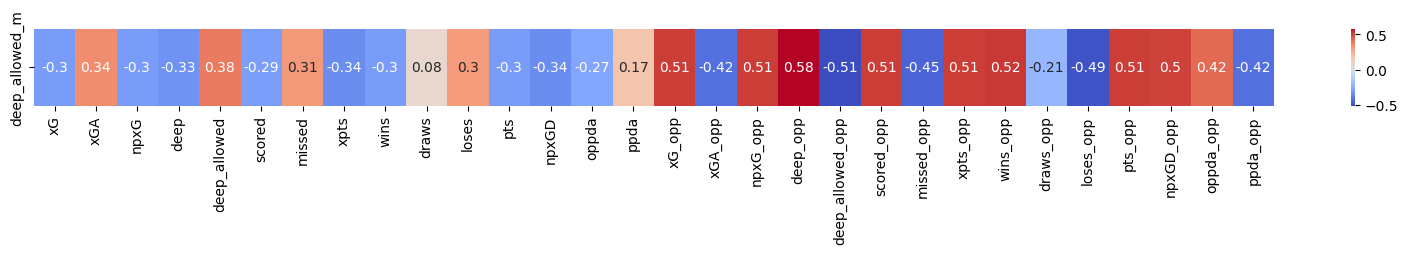

In [140]:
plt.figure(figsize=(20, 1))
sns.heatmap(games_reg_match_dp_all.corr()[['deep_allowed_m']].T.drop('deep_allowed_m', axis = 1).round(2), annot=True, cmap='coolwarm', linewidths=0)
plt.show()

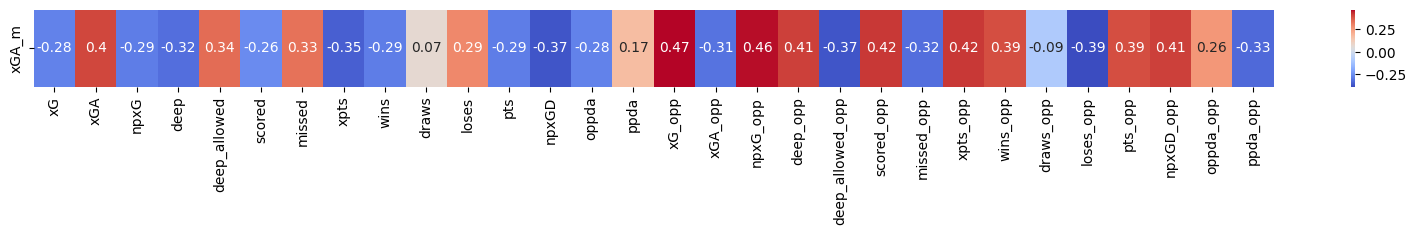

In [141]:
games_reg_match_xGA_m = games_reg_match[['xG', 'xGA', 'npxG', 'deep', 'deep_allowed', 'scored',
       'missed', 'xpts', 'wins', 'draws', 'loses', 'pts', 'npxGD', 'oppda',
       'ppda', 'xG_opp',
       'xGA_opp', 'npxG_opp', 'deep_opp', 'deep_allowed_opp', 'scored_opp',
       'missed_opp', 'xpts_opp', 'wins_opp', 'draws_opp', 'loses_opp',
       'pts_opp', 'npxGD_opp', 'oppda_opp', 'ppda_opp', 'xGA_m'
                                  ]]

plt.figure(figsize=(20, 1))
sns.heatmap(games_reg_match_xGA_m.corr()[['xGA_m']].T.drop('xGA_m', axis = 1).round(2), annot=True, cmap='coolwarm', linewidths=0)
plt.show()

In [142]:
games_reg_match_xpts_m = games_reg_match[['xG', 'xGA', 'npxG', 'deep', 'deep_allowed', 'scored',
       'missed', 'xpts', 'wins', 'draws', 'loses', 'pts', 'npxGD', 'oppda',
       'ppda', 'xG_opp',
       'xGA_opp', 'npxG_opp', 'deep_opp', 'deep_allowed_opp', 'scored_opp',
       'missed_opp', 'xpts_opp', 'wins_opp', 'draws_opp', 'loses_opp',
       'pts_opp', 'npxGD_opp', 'oppda_opp', 'ppda_opp', 'xpts_m'
                                  ]]

plt.figure(figsize=(20, 1))
sns.heatmap(games_reg_match_xpts_m.corr()[['xpts_m']].T.drop('xpts_m', axis = 1).round(2), annot=True, cmap='coolwarm', linewidths=0)
plt.show()

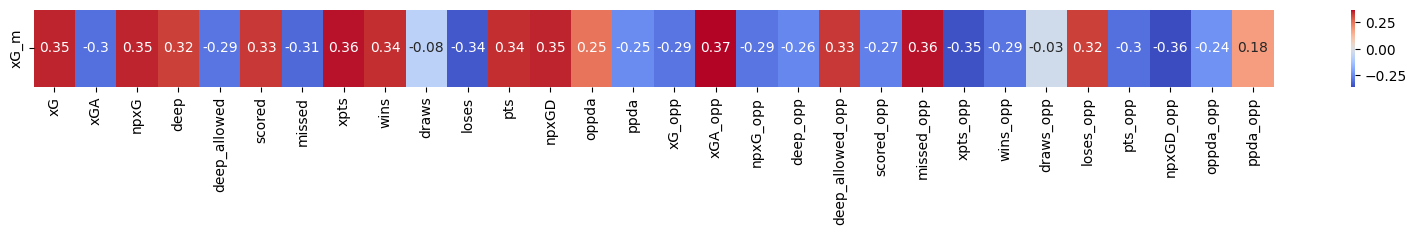

In [143]:
games_reg_match_xG_m = games_reg_match[['xG', 'xGA', 'npxG', 'deep', 'deep_allowed', 'scored',
       'missed', 'xpts', 'wins', 'draws', 'loses', 'pts', 'npxGD', 'oppda',
       'ppda', 'xG_opp',
       'xGA_opp', 'npxG_opp', 'deep_opp', 'deep_allowed_opp', 'scored_opp',
       'missed_opp', 'xpts_opp', 'wins_opp', 'draws_opp', 'loses_opp',
       'pts_opp', 'npxGD_opp', 'oppda_opp', 'ppda_opp', 'xG_m'
                                  ]]

plt.figure(figsize=(20, 1))
sns.heatmap(games_reg_match_xG_m.corr()[['xG_m']].T.drop('xG_m', axis = 1).round(2), annot=True, cmap='coolwarm', linewidths=0)
plt.show()

## 1) General Game Predictions

## Predicting the number of passes the opposing team will make within a maximum of 20 meters of the goal during the match.

### Choosing Variables and Splitting Data for Hold-Out

In [144]:
dependent_var = 'deep_allowed_m'

X = games_reg_match.drop(['team_id_m','team_title', 'id', 'h.id', 'a.id',  'team_id_opp','team_title_opp',
  'xG',
  # 'xGA',
  'npxG',
  'deep',
  # 'deep_allowed',
  'scored',
  'missed',
  # 'xpts',
  # 'wins',
  'draws',
  'loses',
  'pts',
  'npxGD',
  'oppda',
  'ppda',
  'xG_opp',
  'xGA_opp',
  # 'npxG_opp',
  # 'deep_opp',
  'deep_allowed_opp',
  'scored_opp',
  'missed_opp',
  # 'xpts_opp',
  'wins_opp',
  'draws_opp',
  'loses_opp',
  'pts_opp',
  'npxGD_opp',
  'oppda_opp',
  'ppda_opp',
 # 'h_a',
 'xG_m',
 'xGA_m',
 'npxG_m',
 'npxGA',
 'deep_m',
 'deep_allowed_m',
 'scored_m',
 'missed_m',
 'xpts_m',
 'result',
 'wins_m',
 'draws_m',
 'loses_m',
 'pts_m',
 'npxGD_m',
 'team_id_m',
 'team_title_m',
 'ppda_att',
 'ppda_def',
 'ppda_allowed_att',
 'ppda_allowed_def',
 'oppda_m',
 'ppda_m'], axis=1)
y = games_reg_match[dependent_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

### Hyperparameter Tuning

In [ ]:
model = DecisionTreeRegressor()

param_grid = {
    'criterion': ['friedman_mse', 'poisson', 'absolute_error', 'squared_error'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 7, 10, 15, 20],
    'min_samples_leaf': [5, 10, 15, 20, 25],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [ ]:
# svr
model = SVR()

param_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [ ]:
# ann modeli
model = MLPRegressor(max_iter=1000)

param_grid = {
    'hidden_layer_sizes': [(100,50), (1000,), (500,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [148]:
models = {
    'Linear Regression': LinearRegression(),
    'Regression Tree': DecisionTreeRegressor(criterion= 'friedman_mse',
                                             splitter= 'random',
                                             max_depth= 15,
                                             min_samples_split= 25,
                                             min_samples_leaf= 5,
                                             max_features= None),
    'SVR': SVR(C= 10, gamma= 'scale', kernel= 'rbf', degree= 3)
               ,
    'ANN': MLPRegressor(
                        activation= 'relu',
                        alpha= 0.01,
                        hidden_layer_sizes= (100, 50),
                        learning_rate= 'constant',
                        solver= 'sgd',
                        max_iter=1000)
}

### Prediction Results

In [ ]:
results = {}
results_train = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, predictions)
    
    results[name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r_squared
    }

    predictions_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, predictions_train)
    mae_train = mean_absolute_error(y_train, predictions_train)
    rmse_train = np.sqrt(mse_train)
    r_squared_train = r2_score(y_train, predictions_train)
    
    results_train[name] = {
        'MSE': mse_train,
        'MAE': mae_train,
        'RMSE': rmse_train,
        'R-squared': r_squared_train
    }


models = pd.DataFrame(columns = list(range(8)))
models.columns = pd.MultiIndex.from_tuples([('Linear Regression', 'test'),
                                 ('Linear Regression', 'train'),
                                 ('Regression Tree', 'test'),
                                 ('Regression Tree', 'train'),
                                 ('SVR', 'test'),
                                 ('SVR', 'train'),
                                 ('ANN', 'test'),
                                 ('ANN', 'train')])

for model_name, metrics in results.items():
    # print(f"{model_name} Metrics:")
    # for metric_name, value in metrics.items():
    #     print(f"{metric_name}: {value}")
    # print()
    for metric_name, value in metrics.items():
        models.loc[metric_name, (model_name, 'test')] = value

for model_name, metrics in results_train.items():
    for metric_name, value in metrics.items():
        models.loc[metric_name, (model_name, 'train')] = value
        
print(dependent_var)
models.head()

## Predicting the PPDA (Number of passes allowed to the opposing team within a three-fifths (or 60%) of the pitch where the team is expected execute a high press).

### Choosing Variables and Splitting Data for Hold-Out

In [150]:
dependent_var = 'ppda_m'

X = games_reg_match.drop(['team_id_m','team_title', 'id', 'h.id', 'a.id',  'team_id_opp','team_title_opp',
  # 'xG',
  'xGA',
  'npxG',
  'deep',
  # 'deep_allowed',
  'scored',
  'missed',
  # 'xpts',
  'wins',
  'draws',
  'loses',
  'pts',
  'npxGD',
   'oppda',
  # 'ppda',
  'xG_opp',
  'xGA_opp',
  'npxG_opp',
   'deep_opp',
   'deep_allowed_opp',
  'scored_opp',
  'missed_opp',
  # 'xpts_opp',
  'wins_opp',
  'draws_opp',
  'loses_opp',
  'pts_opp',
  'npxGD_opp',
  # 'oppda_opp',
   'ppda_opp',
# 'h_a',
 'xG_m',
 'xGA_m',
 'npxG_m',
 'npxGA',
 'deep_m',
 'deep_allowed_m',
 'scored_m',
 'missed_m',
 'xpts_m',
 'result',
 'wins_m',
 'draws_m',
 'loses_m',
 'pts_m',
 'npxGD_m',
 'team_id_m',
 'team_title_m',
 'ppda_att',
 'ppda_def',
 'ppda_allowed_att',
 'ppda_allowed_def',
 'oppda_m',
 'ppda_m'], axis=1)
y = games_reg_match[dependent_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

### Hyperparameter Tuning

In [ ]:
# Decision Tree Regressor
model = DecisionTreeRegressor()

param_grid = {
    'criterion': ['friedman_mse', 'poisson', 'absolute_error', 'squared_error'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 7, 10, 15, 20],
    'min_samples_leaf': [5, 10, 15, 20, 25],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [ ]:
# svr
model = SVR()

param_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

# GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# En iyi hiperparametrelerin print edilmesi
print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [ ]:
# ann
model = MLPRegressor(max_iter=1000)

param_grid = {
    'hidden_layer_sizes': [(100,50), (1000,), (500,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [153]:
models = {
    'Linear Regression': LinearRegression(),
    'Regression Tree': DecisionTreeRegressor(criterion= 'absolute_error',
                                             splitter= 'best',
                                             max_depth= None,
                                             min_samples_split= 2,
                                             min_samples_leaf= 3,
                                             max_features= 'log2'),
    'SVR': SVR(C= 100, gamma= 'scale', kernel= 'poly', degree= 5)
               ,
    'ANN': MLPRegressor(
                        activation= 'tanh',
                        alpha= 0.001,
                        hidden_layer_sizes= (100, 50),
                        learning_rate= 'adaptive',
                        solver= 'sgd',
                        max_iter=1000)
}

### Prediction Results

In [ ]:
results = {}
results_train = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, predictions)
    
    results[name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r_squared
    }

    predictions_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, predictions_train)
    mae_train = mean_absolute_error(y_train, predictions_train)
    rmse_train = np.sqrt(mse_train)
    r_squared_train = r2_score(y_train, predictions_train)
    
    results_train[name] = {
        'MSE': mse_train,
        'MAE': mae_train,
        'RMSE': rmse_train,
        'R-squared': r_squared_train
    }


models = pd.DataFrame(columns = list(range(8)))
models.columns = pd.MultiIndex.from_tuples([('Linear Regression', 'test'),
                                 ('Linear Regression', 'train'),
                                 ('Regression Tree', 'test'),
                                 ('Regression Tree', 'train'),
                                 ('SVR', 'test'),
                                 ('SVR', 'train'),
                                 ('ANN', 'test'),
                                 ('ANN', 'train')])

for model_name, metrics in results.items():
    # print(f"{model_name} Metrics:")
    # for metric_name, value in metrics.items():
    #     print(f"{metric_name}: {value}")
    # print()
    for metric_name, value in metrics.items():
        models.loc[metric_name, (model_name, 'test')] = value

for model_name, metrics in results_train.items():
    for metric_name, value in metrics.items():
        models.loc[metric_name, (model_name, 'train')] = value
print(dependent_var)
models.head()

## Predicting the total xG of the team within match

### Choosing Variables and Splitting Data for Hold-Out

In [155]:
dependent_var = 'xG_m'

X = games_reg_match.drop(['team_id_m','team_title', 'id', 'h.id', 'a.id',  'team_id_opp','team_title_opp',
#  'xG',
   'xGA',
  'npxG',
  'deep',
  'deep_allowed',
  'scored',
  'missed',
  # 'xpts',
  'wins',
  'draws',
  'loses',
  'pts',
  'npxGD',
  'oppda',
  'ppda',
 'xG_opp',
#  'xGA_opp',
  'npxG_opp',
  'deep_opp',
  'deep_allowed_opp',
  'scored_opp',
  'missed_opp',
  # 'xpts_opp',
  'wins_opp',
  'draws_opp',
  'loses_opp',
  'pts_opp',
  'npxGD_opp',
  'oppda_opp',
  'ppda_opp',
#'h_a',
 'xG_m',
 'xGA_m',
 'npxG_m',
 'npxGA',
 'deep_m',
 'deep_allowed_m',
 'scored_m',
 'missed_m',
 'xpts_m',
 'result',
 'wins_m',
 'draws_m',
 'loses_m',
 'pts_m',
 'npxGD_m',
 'team_id_m',
 'team_title_m',
 'ppda_att',
 'ppda_def',
 'ppda_allowed_att',
 'ppda_allowed_def',
 'oppda_m',
 'ppda_m'], axis=1)
y = games_reg_match[dependent_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

### Hyperparameter Tuning

In [ ]:
# Decision Tree Regressor
model = DecisionTreeRegressor()

param_grid = {
    'criterion': ['friedman_mse', 'poisson', 'absolute_error', 'squared_error'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 7, 10, 15, 20],
    'min_samples_leaf': [5, 10, 15, 20, 25],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [ ]:
# svr modeli
model = SVR()

param_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [ ]:
# ann modeli
model = MLPRegressor(max_iter=1000)

param_grid = {
    'hidden_layer_sizes': [(100,50), (1000,), (500,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [156]:
models = {
    'Linear Regression': LinearRegression(),
    'Regression Tree': DecisionTreeRegressor(criterion= 'friedman_mse',
                                             splitter= 'random',
                                             max_depth= None,
                                             min_samples_split= 15,
                                             min_samples_leaf= 15,
                                             max_features= 'auto'),
    'SVR': SVR(C= 1, gamma= 'scale', kernel= 'linear', degree= 5)
               ,
    'ANN': MLPRegressor(
                        activation= 'tanh',
                        alpha= 0.001,
                        hidden_layer_sizes= (100, 50),
                        learning_rate= 'adaptive',
                        solver= 'adam',
                        max_iter=1000)
}

### Prediction Results

In [ ]:
results = {}
results_train = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, predictions)
    
    results[name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r_squared
    }

    predictions_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, predictions_train)
    mae_train = mean_absolute_error(y_train, predictions_train)
    rmse_train = np.sqrt(mse_train)
    r_squared_train = r2_score(y_train, predictions_train)
    
    results_train[name] = {
        'MSE': mse_train,
        'MAE': mae_train,
        'RMSE': rmse_train,
        'R-squared': r_squared_train
    }


models = pd.DataFrame(columns = list(range(8)))
models.columns = pd.MultiIndex.from_tuples([('Linear Regression', 'test'),
                                 ('Linear Regression', 'train'),
                                 ('Regression Tree', 'test'),
                                 ('Regression Tree', 'train'),
                                 ('SVR', 'test'),
                                 ('SVR', 'train'),
                                 ('ANN', 'test'),
                                 ('ANN', 'train')])

for model_name, metrics in results.items():

    for metric_name, value in metrics.items():
        models.loc[metric_name, (model_name, 'test')] = value.round(2)

for model_name, metrics in results_train.items():
    for metric_name, value in metrics.items():
        models.loc[metric_name, (model_name, 'train')] = value.round(2)
print(dependent_var)
models.head()

## Predicting the total xG tolerance for opponent of the team within match

### Choosing Variables and Splitting Data for Hold-Out

In [171]:
dependent_var = 'xGA_m'

X = games_reg_match.drop(['team_id_m','team_title', 'id', 'h.id', 'a.id',  'team_id_opp','team_title_opp',
  'xG',
  # 'xGA',
  'npxG',
  'deep',
  'deep_allowed',
  'scored',
  'missed',
  # 'xpts',
  'wins',
  'draws',
  'loses',
  'pts',
  'npxGD',
  'oppda',
  'ppda',
  # 'xG_opp',
  'xGA_opp',
  'npxG_opp',
  'deep_opp',
  'deep_allowed_opp',
  'scored_opp',
  'missed_opp',
  # 'xpts_opp',
  'wins_opp',
  'draws_opp',
  'loses_opp',
  'pts_opp',
  'npxGD_opp',
  'oppda_opp',
  'ppda_opp',
#'h_a',
 'xG_m',
 'xGA_m',
 'npxG_m',
 'npxGA',
 'deep_m',
 'deep_allowed_m',
 'scored_m',
 'missed_m',
 'xpts_m',
 'result',
 'wins_m',
 'draws_m',
 'loses_m',
 'pts_m',
 'npxGD_m',
 'team_id_m',
 'team_title_m',
 'ppda_att',
 'ppda_def',
 'ppda_allowed_att',
 'ppda_allowed_def',
 'oppda_m',
 'ppda_m'], axis=1)
y = games_reg_match[dependent_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

### Hyperparameter Tuning

In [ ]:
# Decision Tree Regressor modeli
model = DecisionTreeRegressor()

param_grid = {
    'criterion': ['friedman_mse', 'poisson', 'absolute_error', 'squared_error'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 7, 10, 15, 20],
    'min_samples_leaf': [5, 10, 15, 20, 25],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [ ]:
# svr modeli
model = SVR()

param_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [ ]:
# ann modeli
model = MLPRegressor(max_iter=1000)

param_grid = {
    'hidden_layer_sizes': [(100,50), (1000,), (500,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [172]:
models = {
    'Linear Regression': LinearRegression(),
    'Regression Tree': DecisionTreeRegressor(criterion= 'poisson',
                                             splitter= 'random',
                                             max_depth= 15,
                                             min_samples_split= 20,
                                             min_samples_leaf= 5,
                                             max_features= 'log2'),
    'SVR': SVR(C= 1, gamma= 'auto', kernel= 'rbf', degree= 5)
               ,
    'ANN': MLPRegressor(
                        activation= 'relu',
                        alpha= 0.01,
                        hidden_layer_sizes= (100, 50),
                        learning_rate= 'adaptive',
                        solver= 'adam',
                        max_iter=1000)
}

### Prediction Results

In [173]:
results = {}
results_train = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, predictions)
    
    results[name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r_squared
    }

    predictions_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, predictions_train)
    mae_train = mean_absolute_error(y_train, predictions_train)
    rmse_train = np.sqrt(mse_train)
    r_squared_train = r2_score(y_train, predictions_train)
    
    results_train[name] = {
        'MSE': mse_train,
        'MAE': mae_train,
        'RMSE': rmse_train,
        'R-squared': r_squared_train
    }


models = pd.DataFrame(columns = list(range(8)))
models.columns = pd.MultiIndex.from_tuples([('Linear Regression', 'test'),
                                 ('Linear Regression', 'train'),
                                 ('Regression Tree', 'test'),
                                 ('Regression Tree', 'train'),
                                 ('SVR', 'test'),
                                 ('SVR', 'train'),
                                 ('ANN', 'test'),
                                 ('ANN', 'train')])

for model_name, metrics in results.items():

    for metric_name, value in metrics.items():
        models.loc[metric_name, (model_name, 'test')] = value

for model_name, metrics in results_train.items():
    for metric_name, value in metrics.items():
        models.loc[metric_name, (model_name, 'train')] = value
print(dependent_var)
models.head()

xGA_m


Linear Regression           Regression Tree                 SVR  \
                       test     train            test     train      test   
MSE                0.928209  0.649471        0.873712  0.642374  0.924348   
MAE                 0.72501  0.649987        0.730859  0.636547  0.776037   
RMSE               0.963436  0.805898        0.934725  0.801482   0.96143   
R-squared         -0.196701  0.428782        -0.12644  0.435024 -0.191723   

                          ANN            
              train      test     train  
MSE        0.543192  1.660662  2.152303  
MAE        0.482669  1.074464  1.269067  
RMSE       0.737015  1.288667  1.467073  
R-squared  0.522256 -1.141021 -0.892979

## Predecting expected points to recieve for the match

### Choosing Variables and Splitting Data for Hold-Out

In [174]:
dependent_var = 'xpts_m'

X = games_reg_match.drop(['team_id_m','team_title', 'id', 'h.id', 'a.id',  'team_id_opp','team_title_opp',
  'xG',
   'xGA',
  'npxG',
  'deep',
  'deep_allowed',
  'scored',
  'missed',
  # 'xpts',
  'wins',
  'draws',
  'loses',
  'pts',
  'npxGD',
  'oppda',
  'ppda',
  # 'xG_opp',
  'xGA_opp',
  'npxG_opp',
  'deep_opp',
  'deep_allowed_opp',
  'scored_opp',
  'missed_opp',
  # 'xpts_opp',
  'wins_opp',
  'draws_opp',
  'loses_opp',
  'pts_opp',
  'npxGD_opp',
  'oppda_opp',
  'ppda_opp',
  # 'h_a',
 'xG_m',
 'xGA_m',
 'npxG_m',
 'npxGA',
 'deep_m',
 'deep_allowed_m',
 'scored_m',
 'missed_m',
 'xpts_m',
 'result',
 'wins_m',
 'draws_m',
 'loses_m',
 'pts_m',
 'npxGD_m',
 'team_id_m',
 'team_title_m',
 'ppda_att',
 'ppda_def',
 'ppda_allowed_att',
 'ppda_allowed_def',
 'oppda_m',
 'ppda_m'], axis=1)
y = games_reg_match[dependent_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

### Hyperparameter Tuning

In [ ]:
# Decision Tree Regressor modeli
model = DecisionTreeRegressor()

param_grid = {
    'criterion': ['friedman_mse', 'poisson', 'absolute_error', 'squared_error'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 7, 10, 15, 20],
    'min_samples_leaf': [5, 10, 15, 20, 25],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [ ]:
# svr modeli
model = SVR()

param_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [ ]:
# ann modeli
model = MLPRegressor(max_iter=1000)

param_grid = {
    'hidden_layer_sizes': [(100,50), (1000,), (500,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [179]:
models = {
    'Linear Regression': LinearRegression(),
    'Regression Tree': DecisionTreeRegressor(criterion= 'poisson',
                                             splitter= 'random',
                                             max_depth= 30,
                                             min_samples_split= 15,
                                             min_samples_leaf= 10,
                                             max_features= 'auto'),
    'SVR': SVR()
               ,
    'ANN': MLPRegressor(
                        activation= 'relu',
                        alpha= 0.1,
                        hidden_layer_sizes= (50,),
                        learning_rate= 'constant',
                        solver= 'adam',
                        max_iter=1000)
}

### Prediction Results

In [180]:
results = {}
results_train = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, predictions)
    
    results[name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r_squared
    }

    predictions_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, predictions_train)
    mae_train = mean_absolute_error(y_train, predictions_train)
    rmse_train = np.sqrt(mse_train)
    r_squared_train = r2_score(y_train, predictions_train)
    
    results_train[name] = {
        'MSE': mse_train,
        'MAE': mae_train,
        'RMSE': rmse_train,
        'R-squared': r_squared_train
    }


models = pd.DataFrame(columns = list(range(8)))
models.columns = pd.MultiIndex.from_tuples([('Linear Regression', 'test'),
                                 ('Linear Regression', 'train'),
                                 ('Regression Tree', 'test'),
                                 ('Regression Tree', 'train'),
                                 ('SVR', 'test'),
                                 ('SVR', 'train'),
                                 ('ANN', 'test'),
                                 ('ANN', 'train')])

for model_name, metrics in results.items():

    for metric_name, value in metrics.items():
        models.loc[metric_name, (model_name, 'test')] = value.round(2)

for model_name, metrics in results_train.items():
    for metric_name, value in metrics.items():
        models.loc[metric_name, (model_name, 'train')] = value.round(2)
print(dependent_var)
models.head()

xpts_m


/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


Linear Regression       Regression Tree         SVR             ANN  \
                       test train            test train  test train      test   
MSE                    0.46  0.39            0.55  0.38  0.59  0.72   7358.77   
MAE                    0.55  0.51            0.61   0.5  0.62   0.7     85.76   
RMSE                   0.68  0.62            0.74  0.62  0.77  0.85     85.78   
R-squared              0.22  0.45            0.06  0.45 -0.01 -0.02 -12490.23   

                    
             train  
MSE        7352.12  
MAE          85.74  
RMSE         85.74  
R-squared -10502.0

## 2) Minute Based Live Match Predictions

### Feature Engineering for Minute Based Predictions

In [ ]:
# df_appear_shots

df_appear_new = df_appear[['goals', 'shots', 'xG', 'time', 'player_id', 'team_id', 'position', 'player', 'h_a', 'yellow_card', 'xA', 'xGChain', 'xGBuildup', 'positionOrder', 'match_id', 'entered']]
df_shots_new = df_shots[['id', 'minute', 'result', 'xG', 'player', 'match_id', 'player_id', 'h_team', 'a_team']]
df_appear_shots = pd.merge(df_appear_new, df_shots_new, on = ['match_id', 'player_id'], how = 'inner',suffixes = ['_match', '_shot'])

# df_status

df_status = pd.DataFrame()

col_min = []
col_match_id = []
col_dif = []

for i in df_shots['match_id'].drop_duplicates():
    for j in range(106):
        col_min.append(j)
        col_match_id.append(i)
        
df_status['match_id'] = col_match_id
df_status['minute'] = col_min

df_status2 = pd.merge(df_status, df_shots, on = ['match_id', 'minute'], how = 'left')
df_status2.fillna(0, inplace = True)

col_dif = []
for i in df_status2['match_id'].drop_duplicates():
    temp_goal_h = 0
    temp_goal_a = 0
    for j in range(106):
        
        temp_filter = df_status2[(df_status2['match_id'] == i) & (df_status2['minute'] == j) & (df_status2['result'] == 'Goal')]
        
        temp_test = temp_filter['h_a']
        if  list(temp_test) == ['h']:
            temp_goal_h += 1
        elif list(temp_test) == ['a']:
            temp_goal_a += 1
        col_dif.append(temp_goal_h - temp_goal_a)
        
df_status['dif'] = col_dif

In [ ]:
#match_id = int(input('Enter the match_id: '))
match_id = 22185
#minute = int(input('Enter the minute: '))
minute = 70
minute_left = 90-minute

In [ ]:
df_shots['isGoal'] = (df_shots['result'] == 'Goal').astype(int)

df_avg_shots = df_shots.groupby(['match_id', 'h_a'])[['xG', 'isGoal']].sum()
df_shots_before = df_shots[df_shots['minute'] < minute].groupby(['match_id', 'h_a'])[['xG', 'isGoal']].sum()
df_shots_after = df_shots[df_shots['minute'] >= minute].groupby(['match_id', 'h_a'])[['xG', 'isGoal']].sum()

df_shots_before.reset_index(inplace = True)
df_shots_after.reset_index(inplace = True)

df_shots_before = df_shots_before[df_shots_before['h_a'] != 0]
df_shots_after = df_shots_after[df_shots_after['h_a'] != 0]

df_minute_shots = pd.merge(df_shots_before, df_shots_after, on = ['match_id', 'h_a'], how = 'outer', suffixes = [f'_before_{minute}', f'_after_{minute}'])
df_minute_shots.fillna(0, inplace = True)

df_minute_shots =  pd.merge(df_minute_shots, df_status[df_status['minute'] == minute], on = ['match_id'], how = 'inner').drop('minute', axis = 1)

df_minute_shots['h_a'] = (df_minute_shots['h_a'] == 'h').astype(int)

temp_dif = df_minute_shots['dif']
df_minute_shots['dif'] =df_minute_shots[df_minute_shots['h_a'] == 0]['dif'].apply(lambda x: 0 - x)
df_minute_shots['dif'].fillna(temp_dif, inplace = True)
df_minute_shots['dif'] = df_minute_shots['dif'].astype(int)

In [ ]:
df_minute_shots

In [ ]:
# our new datasets: games_reg_match, df_xg, df_minute_shots

In [ ]:
games_reg_match.columns

In [ ]:
df_xg.head()

In [ ]:
df_minute_shots.head()

In [ ]:
df_minute_analysis_main = pd.merge(games_reg_match, df_minute_shots, left_on = ['id', 'h_a'], right_on = ['match_id', 'h_a'], how = 'inner')

In [ ]:
df_minute_analysis = df_minute_analysis_main

In [ ]:
df_minute_analysis = df_minute_analysis_main[(df_minute_analysis_main['dif'] == -1) 
                                             & (df_minute_analysis_main['h_a'] == 1)
                                            ]

### Choosing Variables and Splitting Data for Hold-Out

In [ ]:
dependent_var = f'xG_after_{minute}'

X = df_minute_analysis.drop(['team_title',
 'xG',
 'xGA',
 'npxG',
 'deep',
 'deep_allowed',
 'scored',
 'missed',
# 'xpts',
 'wins',
 'draws',
 'loses',
 'pts',
 'npxGD',
 'oppda',
 'ppda',
 'h.id',
 'a.id',
 'id',
 'team_id_opp',
 'team_title_opp',
 'xG_opp',
 'xGA_opp',
 'npxG_opp',
 'deep_opp',
 'deep_allowed_opp',
 'scored_opp',
 'missed_opp',
# 'xpts_opp',
 'wins_opp',
 'draws_opp',
 'loses_opp',
 'pts_opp',
 'npxGD_opp',
 'oppda_opp',
 'ppda_opp',
 'h_a',
 'xG_m',
 'xGA_m',
 'npxG_m',
 'npxGA',
 'deep_m',
 'deep_allowed_m',
 'scored_m',
 'missed_m',
 'xpts_m',
 'result',
 'wins_m',
 'draws_m',
 'loses_m',
 'pts_m',
 'npxGD_m',
 'team_id_m',
 'team_title_m',
 'ppda_att',
 'ppda_def',
 'ppda_allowed_att',
 'ppda_allowed_def',
 'oppda_m',
 'ppda_m',
 'match_id',
# f'xG_before_{minute}',
# f'isGoal_before_{minute}',
 f'xG_after_{minute}',
 f'isGoal_after_{minute}',
# 'dif'
],axis=1)

y = df_minute_analysis[dependent_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

### Hyperparameter Tuning

In [ ]:
# Decision Tree Regressor
model = DecisionTreeRegressor()

param_grid = {
    'criterion': ['friedman_mse', 'poisson', 'absolute_error', 'squared_error'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 7, 10, 15, 20],
    'min_samples_leaf': [5, 10, 15, 20, 25],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [ ]:
# svr
model = SVR()

param_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [ ]:
# ann
model = MLPRegressor(max_iter=1000)

param_grid = {
    'hidden_layer_sizes': [(100,50), (1000,), (500,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Regression Tree': DecisionTreeRegressor(criterion= 'friedman_mse',
                                             splitter= 'best',
                                             max_depth= 25,
                                             min_samples_split= 15,
                                             min_samples_leaf= 15,
                                             max_features= 'log2'),
    'SVR': SVR(C= 1, gamma= 'scale', kernel= 'sigmoid', degree= 5)
               ,
    'ANN': MLPRegressor(
                        activation= 'tanh',
                        alpha= 0.1,
                        hidden_layer_sizes= (100, 50),
                        learning_rate= 'adaptive',
                        solver= 'sgd',
                        max_iter=1000)
}

### Prediction Results

In [ ]:
results = {}
results_train = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, predictions)
    
    results[name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r_squared
    }

    predictions_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, predictions_train)
    mae_train = mean_absolute_error(y_train, predictions_train)
    rmse_train = np.sqrt(mse_train)
    r_squared_train = r2_score(y_train, predictions_train)
    
    results_train[name] = {
        'MSE': mse_train,
        'MAE': mae_train,
        'RMSE': rmse_train,
        'R-squared': r_squared_train
    }


models = pd.DataFrame(columns = list(range(8)))
models.columns = pd.MultiIndex.from_tuples([('Linear Regression', 'test'),
                                 ('Linear Regression', 'train'),
                                 ('Regression Tree', 'test'),
                                 ('Regression Tree', 'train'),
                                 ('SVR', 'test'),
                                 ('SVR', 'train'),
                                 ('ANN', 'test'),
                                 ('ANN', 'train')])

for model_name, metrics in results.items():

    for metric_name, value in metrics.items():
        models.loc[metric_name, (model_name, 'test')] = value.round(2)
for model_name, metrics in results_train.items():
    for metric_name, value in metrics.items():
        models.loc[metric_name, (model_name, 'train')] = value.round(2)
print(dependent_var)
models.head()

## 3) Buildup Based xG Prediction

In [ ]:
df_lineup_analysis_main = pd.merge(games_reg_match, df_xg, left_on = ['id', 'team_id_m'], right_on = ['match_id', 'team_id'], how = 'inner')

### Choosing Variables and Splitting Data for Hold-Out

In [ ]:
dependent_var = 'xG_ma'

X = df_lineup_analysis_main.drop(['team_title',
 'xG',
 'xGA',
 'npxG',
 'deep',
 'deep_allowed',
 'scored',
 'missed',
 'xpts',
 'wins',
 'draws',
 'loses',
# 'pts',
 'npxGD',
 'oppda',
 'ppda',
 'h.id',
 'a.id',
 'id',
 'team_id_opp',
 'team_title_opp',
 'xG_opp',
# 'xGA_opp',
 'npxG_opp',
 'deep_opp',
 'deep_allowed_opp',
 'scored_opp',
 'missed_opp',
 'xpts_opp',
 'wins_opp',
 'draws_opp',
 'loses_opp',
# 'pts_opp',
 'npxGD_opp',
 'oppda_opp',
 'ppda_opp',
# 'h_a',
 'xG_m',
 'xGA_m',
 'npxG_m',
 'npxGA',
 'deep_m',
 'deep_allowed_m',
 'scored_m',
 'missed_m',
 'xpts_m',
 'result',
 'wins_m',
 'draws_m',
 'loses_m',
 'pts_m',
 'npxGD_m',
 'team_id_m',
 'team_title_m',
 'ppda_att',
 'ppda_def',
 'ppda_allowed_att',
 'ppda_allowed_def',
 'oppda_m',
 'ppda_m',
 'match_id',
 'team_id',
 'xGChain_ms',
 'xGBuildup_ms',
# 'xG_ms',
 'xA_ms',
 'goals_ma',
 'assists_ma',
 'shots_ma',
 'key_passes_ma',
 'xGChain_ma',
 'xGBuildup_ma',
 'xG_ma',
 'xA_ma',
 'goals_sga',
 'assists_sga',
 'shots_sga',
 'key_passes_sga',
 'xGChain_sga',
 'xGBuildup_sga',
 'xG_sga',
 'xA_sga'
]
, axis=1)

y = df_lineup_analysis_main[dependent_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

### Hyperparameter Tuning

In [ ]:
# Decision Tree Regressor
model = DecisionTreeRegressor()

param_grid = {
    'criterion': ['friedman_mse', 'poisson', 'absolute_error', 'squared_error'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 7, 10, 15, 20],
    'min_samples_leaf': [5, 10, 15, 20, 25],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [ ]:
# svr
model = SVR()

# Hiperparametrelerin
param_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [ ]:
# ann
model = MLPRegressor(max_iter=1000)

param_grid = {
    'hidden_layer_sizes': [(100,50), (1000,), (500,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("En iyi hiperparametreler: ", grid_search.best_params_)
print("En iyi skor: ", grid_search.best_score_)

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Regression Tree': DecisionTreeRegressor(criterion= 'poisson',
                                             splitter= 'random',
                                             max_depth= None,
                                             min_samples_split= 10,
                                             min_samples_leaf= 15,
                                             max_features= None),
    'SVR': SVR()
               ,
    'ANN': MLPRegressor()
}

### Prediction Results

In [ ]:
results = {}
results_train = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, predictions)
    
    results[name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r_squared
    }

    predictions_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, predictions_train)
    mae_train = mean_absolute_error(y_train, predictions_train)
    rmse_train = np.sqrt(mse_train)
    r_squared_train = r2_score(y_train, predictions_train)
    
    results_train[name] = {
        'MSE': mse_train,
        'MAE': mae_train,
        'RMSE': rmse_train,
        'R-squared': r_squared_train
    }
    

models = pd.DataFrame(columns = list(range(8)))
models.columns = pd.MultiIndex.from_tuples([('Linear Regression', 'test'),
                                 ('Linear Regression', 'train'),
                                 ('Regression Tree', 'test'),
                                 ('Regression Tree', 'train'),
                                 ('SVR', 'test'),
                                 ('SVR', 'train'),
                                 ('ANN', 'test'),
                                 ('ANN', 'train')])

for model_name, metrics in results.items():
    for metric_name, value in metrics.items():
        models.loc[metric_name, (model_name, 'test')] = value.round(2)

for model_name, metrics in results_train.items():
    for metric_name, value in metrics.items():
        models.loc[metric_name, (model_name, 'train')] = value.round(2)
print(dependent_var)
models.head()

# Additional Part: Basketball Data Visualization for Daryl Morey's Analyses in NBA

In [181]:
#pip install nba_api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 7.2 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [192]:
# Data and NBA API
import pandas as pd
import numpy as np

from scipy.stats import norm, gaussian_kde, percentileofscore

pd.options.display.max_columns = None
from nba_api.stats.static import players
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import playercareerstats

# For Shot Chart
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.patches import Circle, Rectangle, Arc, ConnectionPatch
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
from matplotlib.path import Path
from matplotlib.patches import PathPatch

sns.set_style('white')
sns.set_color_codes()

In [193]:
def draw_court(ax=None, color="blue", lw=1, shotzone=False, outer_lines=False, alpha = 1, alpha2 = 1):
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False, alpha = alpha)

    # Create backboard
    backboard = Rectangle((-30, -12.5), 60, 0, linewidth=lw, color=color, alpha = alpha)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, alpha = alpha)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, alpha = alpha)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, alpha = alpha)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', alpha = alpha)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, alpha = alpha)

    # Three point line
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color, alpha = alpha)
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color, alpha = alpha)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color, alpha = alpha)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, alpha = alpha)
    
    # Draw shotzone Lines
    # Based on Advanced Zone Mode
    if (shotzone == True):
        inner_circle = Circle((0, 0), radius=80, linewidth=lw, color='gray', fill=False, alpha = alpha2)
        outer_circle = Circle((0, 0), radius=160, linewidth=lw, color='gray', fill=False, alpha = alpha2)
        corner_three_a_x =  Rectangle((-250, 92.5), 30, 0, linewidth=lw, color='gray', alpha = alpha2)
        corner_three_b_x = Rectangle((220, 92.5), 30, 0, linewidth=lw, color='gray', alpha = alpha2)
        
        # 60 degrees
        inner_line_1 = Rectangle((40, 69.28), 80, 0, 60, linewidth=lw, color='gray', alpha = alpha2)
        # 120 degrees
        inner_line_2 = Rectangle((-40, 69.28), 80, 0, 120, linewidth=lw, color='gray', alpha = alpha2)
        
        # Assume x distance is also 40 for the endpoint
        inner_line_3 = Rectangle((53.20, 150.89), 290, 0, 70.53, linewidth=lw, color='gray', alpha = alpha2)
        inner_line_4 = Rectangle((-53.20, 150.89), 290, 0, 109.47, linewidth=lw, color='gray', alpha = alpha2)
        
        # Assume y distance is also 92.5 for the endpoint
        inner_line_5 = Rectangle((130.54, 92.5), 80, 0, 35.32, linewidth=lw, color='gray', alpha = alpha2)
        inner_line_6 = Rectangle((-130.54, 92.5), 80, 0, 144.68, linewidth=lw, color='gray', alpha = alpha2)
        
        
        # List of the court elements to be plotted onto the axes
        court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                          bottom_free_throw, restricted, corner_three_a,
                          corner_three_b, three_arc, center_outer_arc, inner_circle, outer_circle,
                          corner_three_a_x, corner_three_b_x,
                          inner_line_1, inner_line_2, inner_line_3, inner_line_4, inner_line_5, inner_line_6]
    else:
        # List of the court elements to be plotted onto the axes
        court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                          bottom_free_throw, restricted, corner_three_a,
                          corner_three_b, three_arc, center_outer_arc,]
    
    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)
        

    return ax

In [200]:
df = pd.read_csv("/kaggle/input/nba-shot-locations/NBA Shot Locations 1997 - 2020.csv")

In [201]:
df_before = df[df['Game Date'] < 20130000].sample(n=10000)

df_after = df[df['Game Date'] > 20160000].sample(n=10000)

df_sample = df_before.sample(n=10000)

df_huston_morey = df[(df['Team Name'] == 'Houston Rockets') & (df['Game Date'] > 20130000) & (df['Game Date'] < 20170000)].sample(n=10000)
df_others_morey = df[(df['Team Name'] != 'Houston Rockets') & (df['Game Date'] > 20130000) & (df['Game Date'] < 20170000)].sample(n=10000)


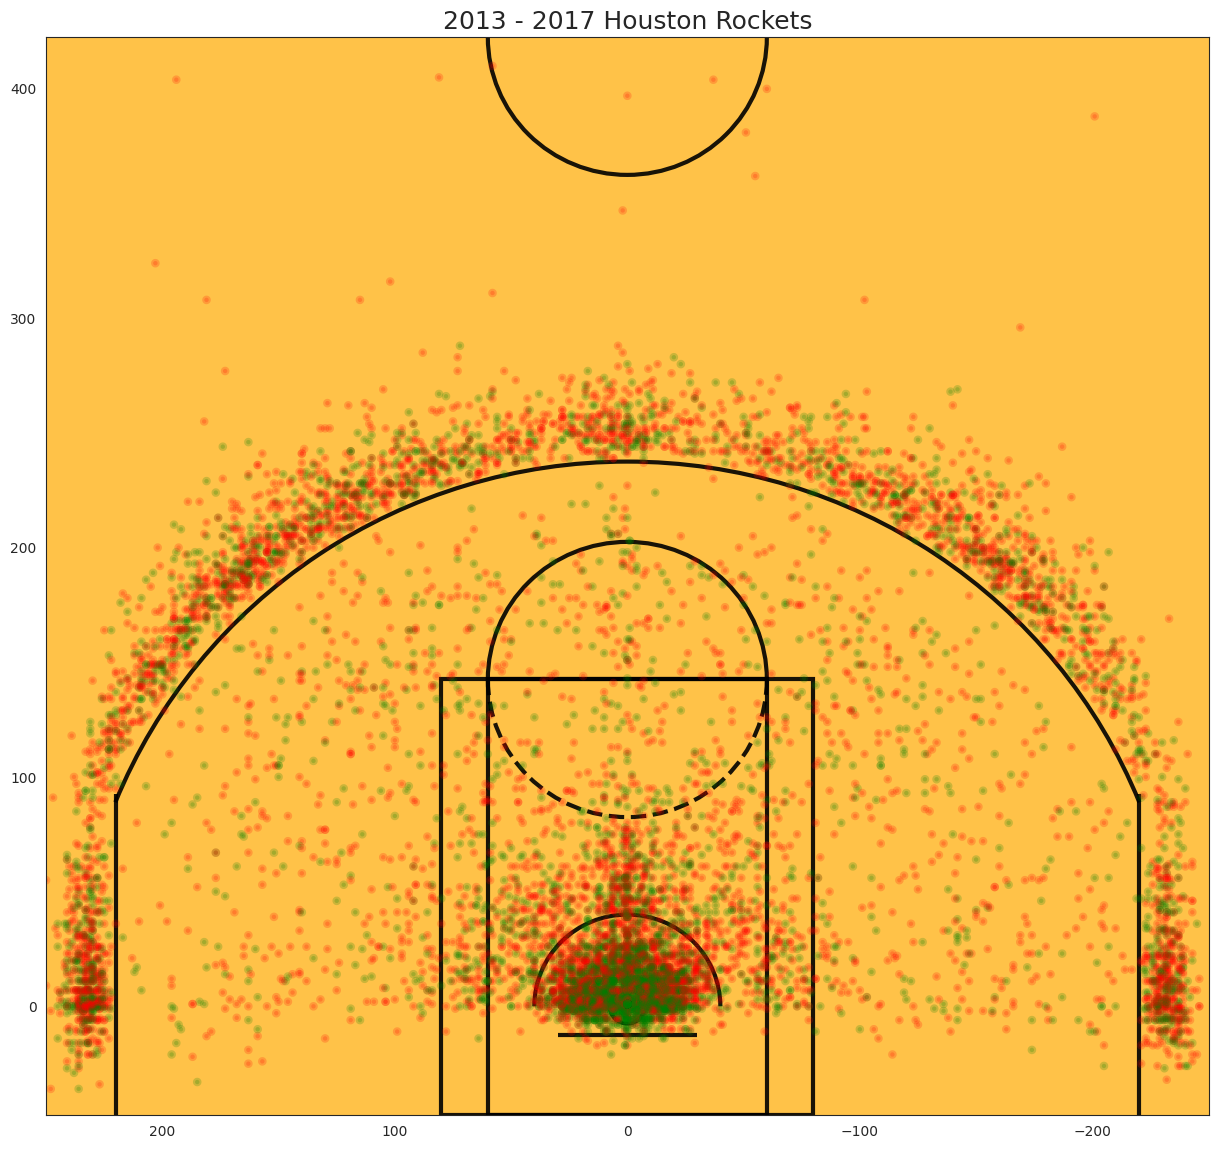

In [202]:
renkler = {1: 'green', 0: 'red'}
kategori_renk = [renkler[i] for i in df_huston_morey['Shot Made Flag']]

plt.figure(figsize=(15, 14))
ax = plt.gca()
ax.set_facecolor((1, 0.7, 0.1, 0.8))
ax.set_xlim(-250, 250)
ax.set_ylim(422.5, -47.5)

ax.set_xlim((-250, 250)[::-1])
ax.set_ylim((422.5, -47.5)[::-1])

ax.tick_params(labelbottom="on", labelleft="on")
ax.set_title('2013 - 2017 Houston Rockets', fontsize=18)
    
draw_court(ax, color='black', lw=3, shotzone=False, outer_lines=False, alpha = 0.9)
    
x_made = df_huston_morey['X Location']
y_made = df_huston_morey['Y Location']
ax.scatter(x_made, y_made,
           c = kategori_renk,
           s=10,
           linewidths=3,
           alpha = 0.2)

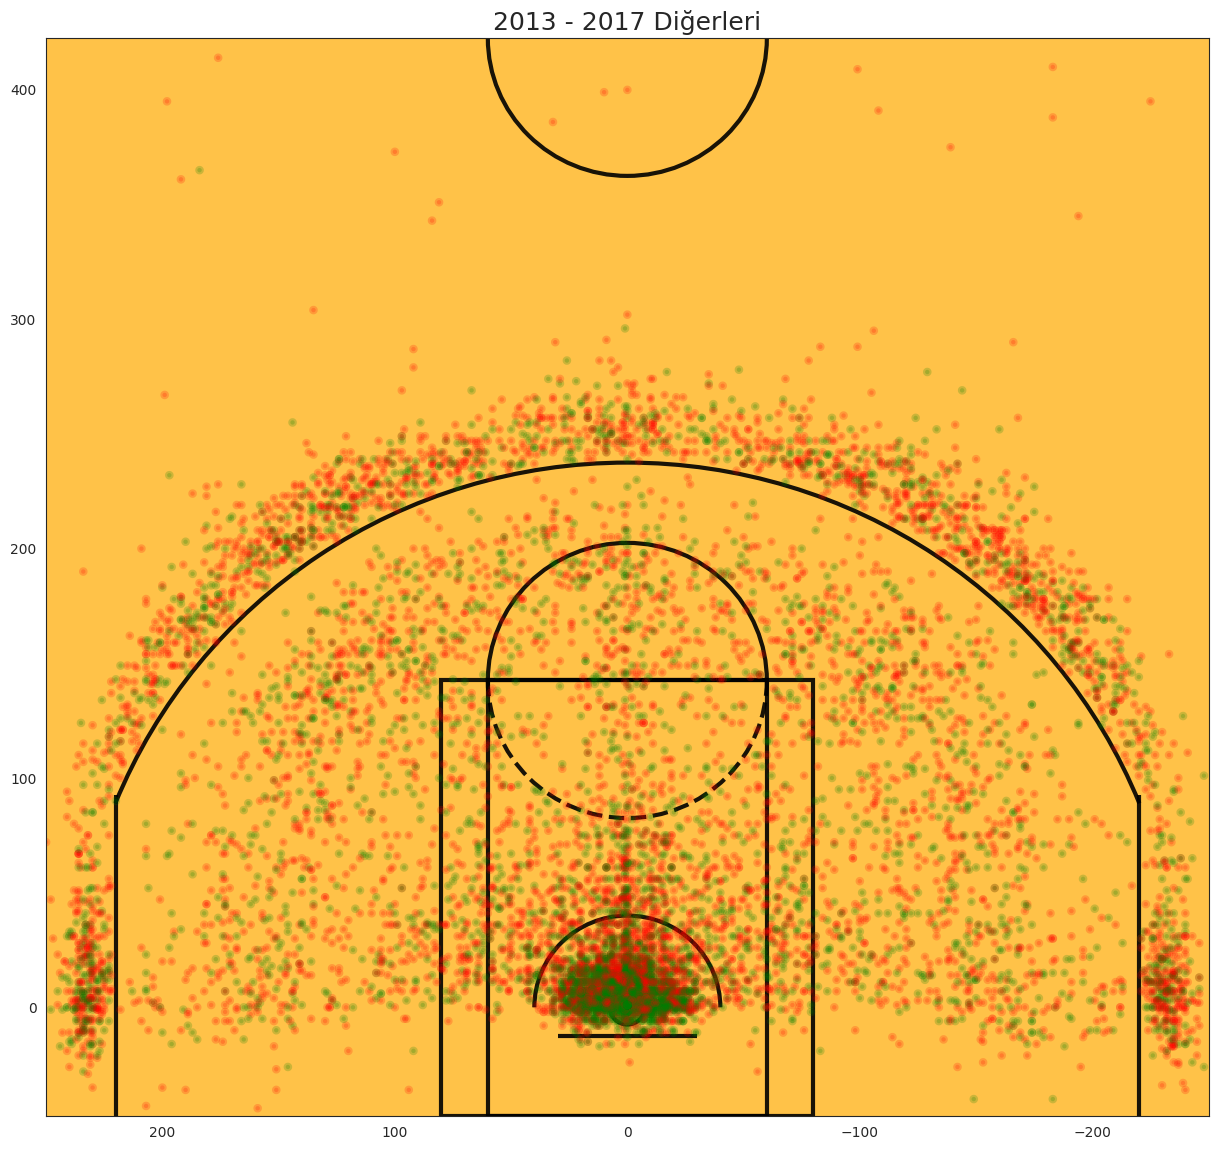

In [203]:
renkler = {1: 'green', 0: 'red'}
kategori_renk = [renkler[i] for i in df_others_morey['Shot Made Flag']]

plt.figure(figsize=(15, 14))
ax = plt.gca()
ax.set_facecolor((1, 0.7, 0.1, 0.8))
ax.set_xlim(-250, 250)
ax.set_ylim(422.5, -47.5)

ax.set_xlim((-250, 250)[::-1])
ax.set_ylim((422.5, -47.5)[::-1])

ax.tick_params(labelbottom="on", labelleft="on")
ax.set_title('2013 - 2017 Diğerleri', fontsize=18)
    
draw_court(ax, color='black', lw=3, shotzone=False, outer_lines=False, alpha = 0.9)
    
x_made = df_others_morey['X Location']
y_made = df_others_morey['Y Location']
ax.scatter(x_made, y_made,
           c = kategori_renk,
           s=10,
           linewidths=3,
           alpha = 0.2)

In [204]:
renkler = {1: 'green', 0: 'red'}
kategori_renk = [renkler[i] for i in df_before['Shot Made Flag']]

plt.figure(figsize=(15, 14))
ax = plt.gca()
ax.set_facecolor((1, 0.7, 0.1, 0.8))
ax.set_xlim(-250, 250)
ax.set_ylim(422.5, -47.5)

ax.set_xlim((-250, 250)[::-1])
ax.set_ylim((422.5, -47.5)[::-1])

ax.tick_params(labelbottom="on", labelleft="on")
ax.set_title('2013 Öncesi NBA Şutları', fontsize=18)
    
draw_court(ax, color='black', lw=3, shotzone=False, outer_lines=False, alpha = 0.9)
    
x_made = df_before['X Location']
y_made = df_before['Y Location']
ax.scatter(x_made, y_made,
           c = kategori_renk,
           s=10,
           linewidths=3,
           alpha = 0.2)

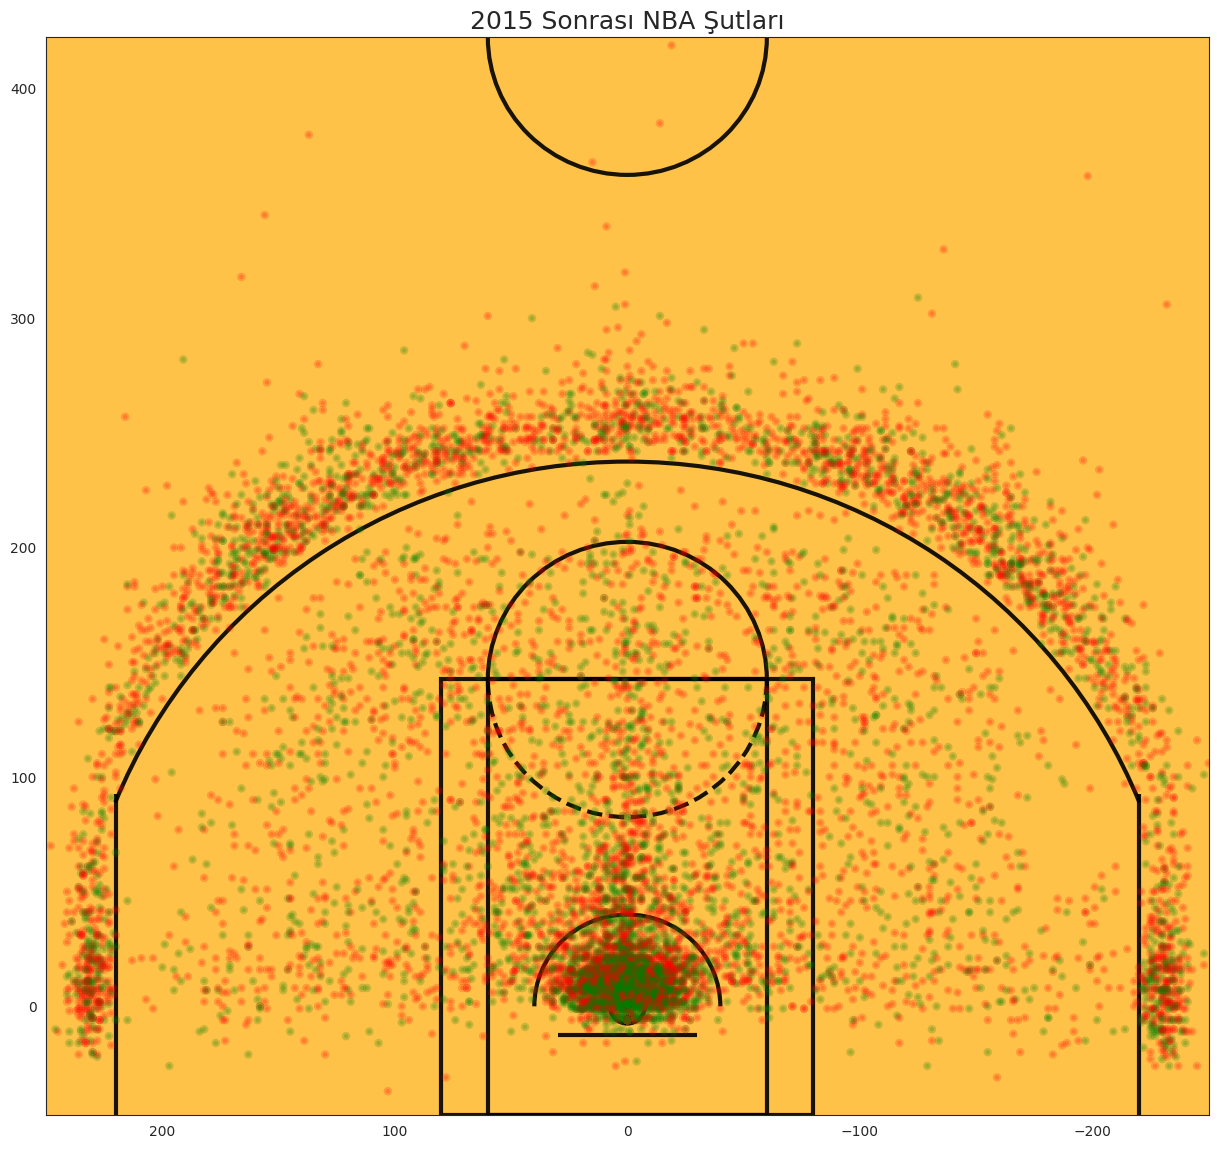

In [205]:
renkler = {1: 'green', 0: 'red'}
kategori_renk = [renkler[i] for i in df_after['Shot Made Flag']]


plt.figure(figsize=(15, 14))
ax = plt.gca()
ax.set_facecolor((1, 0.7, 0.1, 0.8))
ax.set_xlim(-250, 250)
ax.set_ylim(422.5, -47.5)

ax.set_xlim((-250, 250)[::-1])
ax.set_ylim((422.5, -47.5)[::-1])

ax.tick_params(labelbottom="on", labelleft="on")
ax.set_title('2015 Sonrası NBA Şutları', fontsize=18)
    
draw_court(ax, color='black', lw=3, shotzone=False, outer_lines=False, alpha = 0.9)
    
x_made = df_after['X Location']
y_made = df_after['Y Location']
ax.scatter(x_made, y_made,
           c = kategori_renk,
           s=10,
           linewidths=3,
           alpha = 0.2)

/tmp/ipykernel_36/1001248479.py:54: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  inner_line_1 = Rectangle((40, 69.28), 80, 0, 60, linewidth=lw, color='gray', alpha = alpha2)
/tmp/ipykernel_36/1001248479.py:56: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  inner_line_2 = Rectangle((-40, 69.28), 80, 0, 120, linewidth=lw, color='gray', alpha = alpha2)
/tmp/ipykernel_36/1001248479.py:59: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  inner_line_3 = Rectangle((53.20, 150.89), 290, 0, 70.53, linewidth=lw, color='gray', alpha = alpha2)
/tmp/ipykernel_36/1001248479.py:60: Mat

<Axes: >

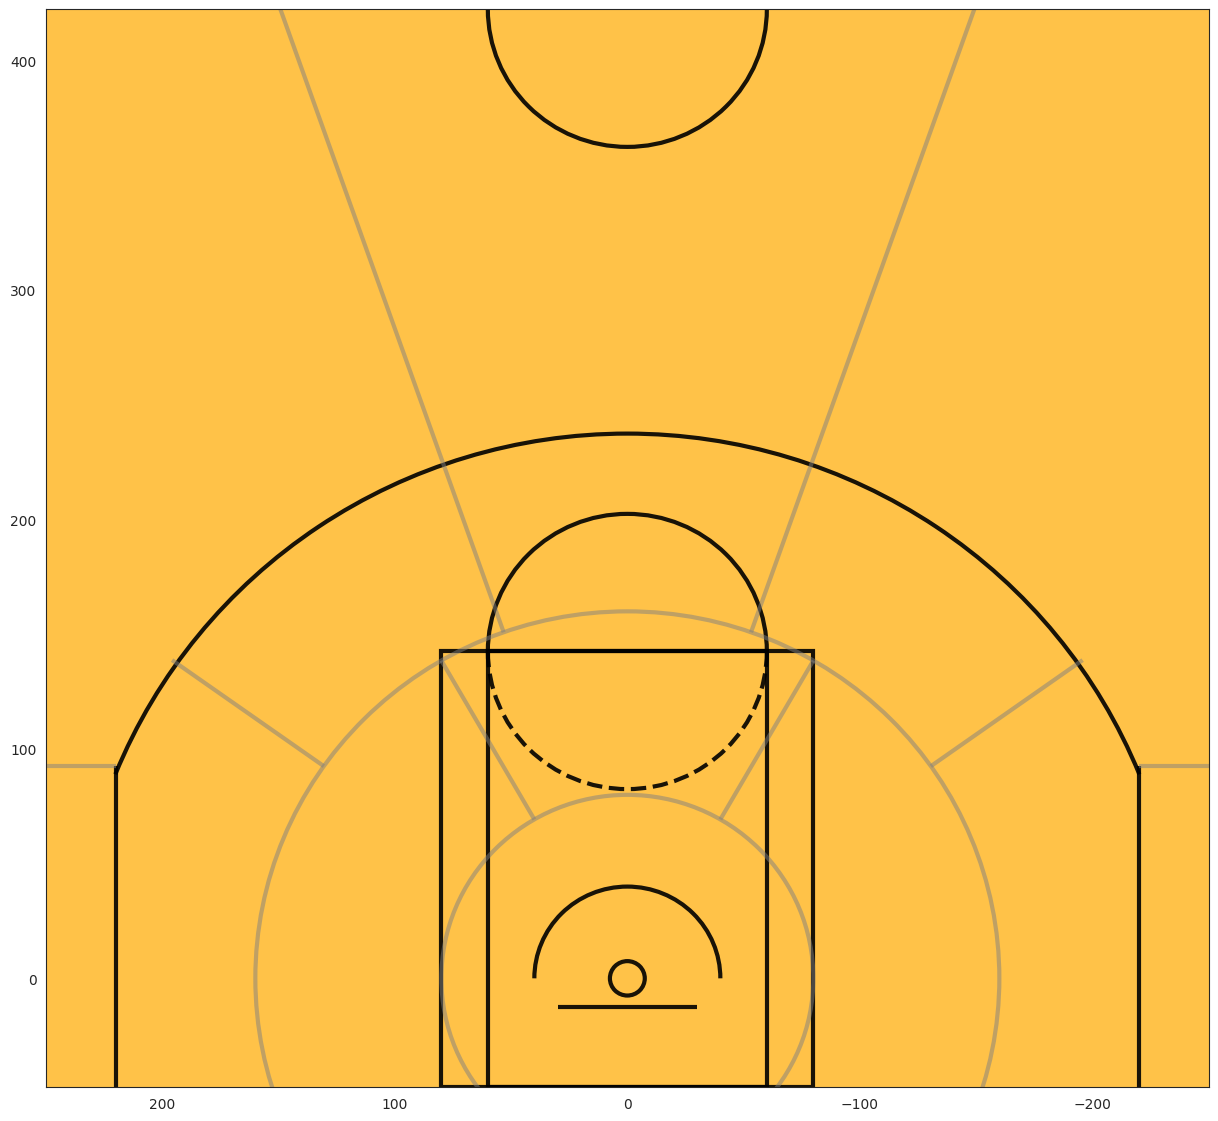

In [206]:
plt.figure(figsize=(15, 14))
ax = plt.gca()
ax.set_facecolor((1, 0.7, 0.1, 0.8))
ax.set_xlim(-250, 250)
ax.set_ylim(422.5, -47.5)

ax.set_xlim((-250, 250)[::-1])
ax.set_ylim((422.5, -47.5)[::-1])

ax.tick_params(labelbottom="on", labelleft="on")
    
draw_court(ax, color='black', lw=3, shotzone=True, outer_lines=False, alpha2 = 0.5, alpha = 0.9)

In [207]:
df_ratio = pd.crosstab([df['Shot Zone Basic'], df['Shot Zone Area']], df['Shot Made Flag'])

df_ratio_sum = df_ratio[1] + df_ratio[0]

df_ratio['acc'] = df_ratio[1] / df_ratio_sum



df_ratio['points'] = [3,3,3,3,3,2,2,2,3,2,2,2,2,2,2,3]

df_ratio['point_acc'] = df_ratio['points'] * df_ratio['acc']

df_ratio

Shot Made Flag                                    0       1       acc  points  \
Shot Zone Basic       Shot Zone Area                                            
Above the Break 3     Back Court(BC)           2057      81  0.037886       3   
                      Center(C)              126641   66175  0.343203       3   
                      Left Side Center(LC)   207491  111519  0.349578       3   
                      Right Side Center(RC)  203447  110938  0.352873       3   
Backcourt             Back Court(BC)           9219     242  0.025579       3   
In The Paint (Non-RA) Center(C)              357146  232129  0.393923       2   
                      Left Side(L)            28120   18571  0.397743       2   
                      Right Side(R)           28942   18840  0.394291       2   
Left Corner 3         Left Side(L)            90512   56531  0.384452       3   
Mid-Range             Center(C)              122986   83852  0.405399       2   
                      Left Side Center(LC)   118353   78563  0.398967       2   
                      Left Side(L)           257026  163941  0.389439       2   
                      Right Side Center(RC)  127667   84897  0.399395       2   
                      Right Side(R)          232677  147663  0.388239       2   
Restricted Area       Center(C)              596209  909712  0.604090       2   
Right Corner 3        Right Side(R)           84305   53060  0.386270       3   

Shot Made Flag                               point_acc  
Shot Zone Basic       Shot Zone Area                    
Above the Break 3     Back Court(BC)          0.113658  
                      Center(C)               1.029609  
                      Left Side Center(LC)    1.048735  
                      Right Side Center(RC)   1.058619  
Backcourt             Back Court(BC)          0.076736  
In The Paint (Non-RA) Center(C)               0.787846  
                      Left Side(L)            0.795485  
                      Right Side(R)           0.788581  
Left Corner 3         Left Side(L)            1.153357  
Mid-Range             Center(C)               0.810799  
                      Left Side Center(LC)    0.797934  
                      Left Side(L)            0.778878  
                      Right Side Center(RC)   0.798790  
                      Right Side(R)           0.776479  
Restricted Area       Center(C)               1.208180  
Right Corner 3        Right Side(R)           1.158810

In [208]:
df_before = df[df['Game Date'] < 20130000]

df_after = df[df['Game Date'] > 20160000]
df_ratio_before = pd.crosstab([df_before['Shot Zone Basic'], df_before['Shot Zone Area']], df_before['Shot Made Flag'])

df_ratio_sum = df_ratio_before[1] + df_ratio_before[0]

df_ratio_before['acc'] = df_ratio_before[1] / df_ratio_sum



df_ratio_before['points'] = [3,3,3,3,3,2,2,2,3,2,2,2,2,2,2,3]

df_ratio_before['point_acc'] = df_ratio_before['points'] * df_ratio_before['acc']

df_ratio_before

Shot Made Flag                                    0       1       acc  points  \
Shot Zone Basic       Shot Zone Area                                            
Above the Break 3     Back Court(BC)           1641      53  0.031287       3   
                      Center(C)               62446   32018  0.338944       3   
                      Left Side Center(LC)   113701   60733  0.348172       3   
                      Right Side Center(RC)  112314   61563  0.354061       3   
Backcourt             Back Court(BC)           5624     152  0.026316       3   
In The Paint (Non-RA) Center(C)              225379  144716  0.391024       2   
                      Left Side(L)            19114   12439  0.394226       2   
                      Right Side(R)           19408   12380  0.389455       2   
Left Corner 3         Left Side(L)            51410   31992  0.383588       3   
Mid-Range             Center(C)               81282   55281  0.404802       2   
                      Left Side Center(LC)    85503   56993  0.399962       2   
                      Left Side(L)           202168  127969  0.387624       2   
                      Right Side Center(RC)   92204   61568  0.400385       2   
                      Right Side(R)          181265  113829  0.385738       2   
Restricted Area       Center(C)              390951  581135  0.597823       2   
Right Corner 3        Right Side(R)           47804   29982  0.385442       3   

Shot Made Flag                               point_acc  
Shot Zone Basic       Shot Zone Area                    
Above the Break 3     Back Court(BC)          0.093861  
                      Center(C)               1.016832  
                      Left Side Center(LC)    1.044515  
                      Right Side Center(RC)   1.062182  
Backcourt             Back Court(BC)          0.078947  
In The Paint (Non-RA) Center(C)               0.782048  
                      Left Side(L)            0.788451  
                      Right Side(R)           0.778910  
Left Corner 3         Left Side(L)            1.150764  
Mid-Range             Center(C)               0.809604  
                      Left Side Center(LC)    0.799924  
                      Left Side(L)            0.775248  
                      Right Side Center(RC)   0.800770  
                      Right Side(R)           0.771476  
Restricted Area       Center(C)               1.195645  
Right Corner 3        Right Side(R)           1.156326

In [209]:
df_ratio_after = pd.crosstab([df_after['Shot Zone Basic'], df_after['Shot Zone Area']], df_after['Shot Made Flag'])

df_ratio_sum_after = df_ratio_after[1] + df_ratio_after[0]

df_ratio_after['acc'] = df_ratio_after[1] / df_ratio_sum_after



df_ratio_after['points'] = [3,3,3,3,3,2,2,2,3,2,2,2,2,2,2,3]

df_ratio_after['point_acc'] = df_ratio_after['points'] * df_ratio_after['acc']

df_ratio_after

Shot Made Flag                                    0       1       acc  points  \
Shot Zone Basic       Shot Zone Area                                            
Above the Break 3     Back Court(BC)            231      18  0.072289       3   
                      Center(C)               44563   23845  0.348570       3   
                      Left Side Center(LC)    62179   33961  0.353245       3   
                      Right Side Center(RC)   59668   32552  0.352982       3   
Backcourt             Back Court(BC)           2251      47  0.020453       3   
In The Paint (Non-RA) Center(C)               80006   54050  0.403190       2   
                      Left Side(L)             5522    3719  0.402446       2   
                      Right Side(R)            5586    3896  0.410884       2   
Left Corner 3         Left Side(L)            24642   15470  0.385670       3   
Mid-Range             Center(C)               23039   16205  0.412929       2   
                      Left Side Center(LC)    16710   11106  0.399267       2   
                      Left Side(L)            26684   17782  0.399901       2   
                      Right Side Center(RC)   17931   11944  0.399799       2   
                      Right Side(R)           25609   17069  0.399948       2   
Restricted Area       Center(C)              120893  199753  0.622971       2   
Right Corner 3        Right Side(R)           23149   14579  0.386424       3   

Shot Made Flag                               point_acc  
Shot Zone Basic       Shot Zone Area                    
Above the Break 3     Back Court(BC)          0.216867  
                      Center(C)               1.045711  
                      Left Side Center(LC)    1.059736  
                      Right Side Center(RC)   1.058946  
Backcourt             Back Court(BC)          0.061358  
In The Paint (Non-RA) Center(C)               0.806379  
                      Left Side(L)            0.804891  
                      Right Side(R)           0.821768  
Left Corner 3         Left Side(L)            1.157010  
Mid-Range             Center(C)               0.825859  
                      Left Side Center(LC)    0.798533  
                      Left Side(L)            0.799802  
                      Right Side Center(RC)   0.799598  
                      Right Side(R)           0.799897  
Restricted Area       Center(C)               1.245941  
Right Corner 3        Right Side(R)           1.159272